# Flight Price Forecast - Kayak


This notebook presents a full data science pipeline for forecasting flight prices using data from the **Kayak** platform.  
The process begins with structured data cleaning and preprocessing, including handling missing values, converting date and duration fields, and encoding categorical features (such as number of stops).

Following the preparation phase, we explore the data (EDA) to uncover trends, distributions, and potential outliers.

Then, we evaluate multiple regression models for price prediction, including:

- **Linear Regression**
- **Decision Tree**
- **Gaussian Process**
- **Random Forest**
- **K-Nearest Neighbors**
- **Multi-layer Perceptron**
- **XGBoost**
- **HistGradientBoosting**

Each model is assessed using metrics like: **R², RMSE, MSE**, and **MAE**.  
To enhance interpretation, we include **residual plots**, **feature importance (permutation)**, and **actual vs. predicted** visualizations.

 This analysis is part of a dual-platform comparison (Kiwi & Kayak).  
A separate notebook applies the same methodology to the Kayak dataset.

## Stage No. 1: collecting the data:
- for this stage we will use a web scraper-collector that will collect flights data from two websites: Kiwi and Kayak.
- this collector is built with async-runtime functions, random user-actions generator, session saver, cookies saver, dynamic viewport and even DHCP-ip-refresher function (since were not using proxy), all of these methods are used for collecting without getting cought by these websities bot-identifier machenisms...
- this collector will run every combination of ttt (time to travel) from 1-30, los (lenght of stay) from 1-5 within a 3 different snapshot days for every combination of rome,london and paris routes

In [1]:
%pip install -e scraping
# %playwright install

Obtaining file:///C:/Users/LaurenM/OneDrive/Desktop/flight_price_forecasting_and_clustering/scraping
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for scraping (pyproject.toml): started
  Building editable for scraping (pyproject.toml): finished with status 'done'
  Created wheel for scraping: filename=scraping-0.1-0.editable-py3-none-any.whl size=2637 sha256=3ccc61a858e6eb8d5b983fce326337bdd75c750d5af3e0ab1ccfd7a1c3cc89de
  Stored in directory: C:\Users\LaurenM\AppData\Local\Temp\pip-ephem-wheel-cache-xl0xr1se\wheels\4f\61\


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re, time, random, datetime, math
from datetime import datetime
from tqdm import tqdm

In [3]:
##################### Preprocessing imports 
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder, HashingEncoder, CountEncoder
from sklearn.impute import KNNImputer

##################### Metrics
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

##################### Models
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline

##################### Model selection 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingRegressor
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor
from scipy.stats import skew, kurtosis

##################### optuna library import
# !pip install shap
import optuna
import shap
import matplotlib.cm as cm
from collections import defaultdict
from currency_converter import CurrencyConverter

##################### Basic settings
random_state = 42
n_splits = 5

 Exploring the data

In [4]:
data = pd.read_csv('data_kayak_balanced.csv')

In [5]:
# Table for first look
def summary(train):
    sum = pd.DataFrame(train.dtypes, columns=['dtypes'])
    sum['missing#'] = train.isna().sum()
    sum['missing%'] = (train.isna().sum())/len(train)
    sum['uniques'] = train.nunique().values
    sum['count'] = train.count().values
    return sum

display(summary(data).style.background_gradient(cmap='Blues'))
data.head()

,dtypes,missing#,missing%,uniques,count
departure_hour,object,8164,0.084085,210,88928
departure_airport,object,8164,0.084085,13,88928
flight_length,object,8164,0.084085,109,88928
landing_hour,object,8164,0.084085,224,88928
landing_airport,object,8164,0.084085,13,88928
to_dest_company,object,8164,0.084085,21,88928
return_departure_hour,object,8164,0.084085,213,88928
return_departure_airport,object,8164,0.084085,13,88928
return_flight_length,object,8164,0.084085,119,88928
return_landing_hour,object,8164,0.084085,233,88928


,departure_hour,departure_airport,flight_length,landing_hour,landing_airport,to_dest_company,return_departure_hour,return_departure_airport,return_flight_length,return_landing_hour,...,ttt,los,snapshot_date,origin_city,destination_city,departure_date,return_date,website,layover_time,return_layover_time
0,1:50p,LGW,1h 15m,4:05p,CDG,easyJet,9:10p,CDG,1h 05m,9:15p,...,2,5,2025-02-28,LONDON,PARIS,2025-03-02,2025-03-07,Kayak,0m,0m
1,6:30p,FCO,2h 50m,8:20p,LGW,Wizz Air,6:45a,LGW,2h 30m,10:15a,...,7,4,2025-03-02,ROME,LONDON,2025-03-09,2025-03-13,Kayak,0m,0m
2,6:25p,FCO,2h 45m,8:10p,LGW,Vueling,8:50p,LGW,2h 20m,12:10a+1,...,12,3,2025-02-28,ROME,LONDON,2025-03-12,2025-03-15,Kayak,0m,0m
3,5:10p,ORY,1h 55m,7:05p,FCO,Vueling,8:20p,FCO,2h 10m,10:30p,...,6,5,2025-02-28,PARIS,ROME,2025-03-06,2025-03-11,Kayak,0m,0m
4,7:45p,FCO,2h 10m,9:55p,ORY,Vueling,7:00a,ORY,4h 25m,11:25a,...,5,5,2025-02-28,ROME,PARIS,2025-03-05,2025-03-10,Kayak,0m,2h 15m


##  Preprocessing
<!-- <ul>
    <li>basic_cleanups</li>
    <li></li>
    <li></li>
</ul> -->

the price is still an object! we need to convert it to numerical... (with scraping knowlage we know that kiwi gives the price in nis and kayak in $)

In [6]:
%pip install currencyconverter

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
def basic_cleanups(data):
    data = data.drop_duplicates()
    data = data.dropna()

    c = CurrencyConverter()

    data['price'] = data['price'].apply(
        lambda x: (
            c.convert(float(x.replace('₪ ', '').replace(',', '')), 'ILS', 'USD') if '₪ ' in x
            else float(x.replace('$', '').replace(',', '')) if '$' in x 
            else None 
        )
    )
    return data

we will add a function that will convert the time strings to int (in minutes)

In [8]:
def time_to_minutes(time_str: str)-> int:
    if pd.isna(time_str):
        return 0

    # Extract hours and minutes using regex
    hours = 0
    minutes = 0
    
    h_match = re.search(r'(\d+)h', time_str)
    m_match = re.search(r'(\d+)m', time_str)

    if h_match:
        hours = int(h_match.group(1))
    if m_match:
        minutes = int(m_match.group(1))

    return hours * 60 + minutes

In [9]:
def hour_to_numeric(hour_str):
    '''
    convert the hours to int format
    '''
    hour_str = hour_str.strip()  

    match = re.search(r"\+(\d+)", hour_str)
    extra_days = int(match.group(1)) if match else 0
    hour_str = re.sub(r"\+\d+", "", hour_str)
    
    if 'a' in hour_str or 'p' in hour_str:
        hour_str = hour_str.replace('a', 'AM').replace('p', 'PM')

        time_obj = datetime.strptime(hour_str, "%I:%M%p")
    else:
        time_obj = datetime.strptime(hour_str, "%H:%M")

    hour_float = time_obj.hour + time_obj.minute / 60

    hour_float += extra_days * 24

    return hour_float

In [10]:
def preprocessing(data):
    # perform basic cleanups
    data = basic_cleanups(data)

    # convert time to minutes
    data['flight_length'] = data['flight_length'].apply(time_to_minutes)
    data['return_flight_length'] = data['return_flight_length'].apply(time_to_minutes)
    data['layover_time'] = data['layover_time'].apply(time_to_minutes)
    data['return_layover_time'] = data['return_layover_time'].apply(time_to_minutes)

    # convert hours to numeric
    data['departure_hour'] = data['departure_hour'].apply(hour_to_numeric)
    data['landing_hour'] = data['landing_hour'].apply(hour_to_numeric)
    data['return_departure_hour'] = data['return_departure_hour'].apply(hour_to_numeric)
    data['return_landing_hour'] = data['return_landing_hour'].apply(hour_to_numeric)

    # convert date to datetime
    ## we know that dates are tied to day of week, lets create new feature based on the departure date!
    data['departure_date'] = pd.to_datetime(data['departure_date'])
    data['day_of_week'] = data['departure_date'].dt.day_name()

    # create new feature based on the origin_city and destination_city
    data['route'] = data['origin_city'] + '_' + data['destination_city']

    return data

data = preprocessing(data)
data.head()

,departure_hour,departure_airport,flight_length,landing_hour,landing_airport,to_dest_company,return_departure_hour,return_departure_airport,return_flight_length,return_landing_hour,...,snapshot_date,origin_city,destination_city,departure_date,return_date,website,layover_time,return_layover_time,day_of_week,route
0,13.833333,LGW,75,16.083333,CDG,easyJet,21.166667,CDG,65,21.250000,...,2025-02-28,LONDON,PARIS,2025-03-02,2025-03-07,Kayak,0,0,Sunday,LONDON_PARIS
1,18.500000,FCO,170,20.333333,LGW,Wizz Air,6.750000,LGW,150,10.250000,...,2025-03-02,ROME,LONDON,2025-03-09,2025-03-13,Kayak,0,0,Sunday,ROME_LONDON
2,18.416667,FCO,165,20.166667,LGW,Vueling,20.833333,LGW,140,24.166667,...,2025-02-28,ROME,LONDON,2025-03-12,2025-03-15,Kayak,0,0,Wednesday,ROME_LONDON
3,17.166667,ORY,115,19.083333,FCO,Vueling,20.333333,FCO,130,22.500000,...,2025-02-28,PARIS,ROME,2025-03-06,2025-03-11,Kayak,0,0,Thursday,PARIS_ROME
4,19.750000,FCO,130,21.916667,ORY,Vueling,7.000000,ORY,265,11.416667,...,2025-02-28,ROME,PARIS,2025-03-05,2025-03-10,Kayak,0,135,Wednesday,ROME_PARIS


In the Kayak dataset, we found an extremely invalid return landing hour value (114.4) which is not realistic for any flight. This outlier suggests that a dedicated cleaning step—similar to the one applied in the Kiwi dataset—should be included to handle such anomalies.



In [11]:
value_counts = data['return_departure_airport'].value_counts()

# Temporarily increase the maximum rows to display
with pd.option_context('display.max_rows', None):
    print(value_counts)

return_departure_airport
FCO    20399
ORY    17807
LGW    17511
CDG    12296
STN     7398
LHR     3590
LTN     3478
CIA     3228
BVA     2342
SEN      272
LCY      252
PAR       49
LON       31
Name: count, dtype: int64


In [12]:
def replace_time_with_nan(df, column_name):
    """Replaces time patterns (HH:MM) in a specified DataFrame column with NaN."""

    time_pattern = r'^\d{2}:\d{2}$'  # Matches HH:MM format (e.g., 11:35)

    df[column_name] = df[column_name].replace(to_replace=time_pattern, value=np.nan, regex=True)

    return df

replace_time_with_nan(data,'return_departure_airport')

,departure_hour,departure_airport,flight_length,landing_hour,landing_airport,to_dest_company,return_departure_hour,return_departure_airport,return_flight_length,return_landing_hour,...,snapshot_date,origin_city,destination_city,departure_date,return_date,website,layover_time,return_layover_time,day_of_week,route
0,13.833333,LGW,75,16.083333,CDG,easyJet,21.166667,CDG,65,21.250000,...,2025-02-28,LONDON,PARIS,2025-03-02,2025-03-07,Kayak,0,0,Sunday,LONDON_PARIS
1,18.500000,FCO,170,20.333333,LGW,Wizz Air,6.750000,LGW,150,10.250000,...,2025-03-02,ROME,LONDON,2025-03-09,2025-03-13,Kayak,0,0,Sunday,ROME_LONDON
2,18.416667,FCO,165,20.166667,LGW,Vueling,20.833333,LGW,140,24.166667,...,2025-02-28,ROME,LONDON,2025-03-12,2025-03-15,Kayak,0,0,Wednesday,ROME_LONDON
3,17.166667,ORY,115,19.083333,FCO,Vueling,20.333333,FCO,130,22.500000,...,2025-02-28,PARIS,ROME,2025-03-06,2025-03-11,Kayak,0,0,Thursday,PARIS_ROME
4,19.750000,FCO,130,21.916667,ORY,Vueling,7.000000,ORY,265,11.416667,...,2025-02-28,ROME,PARIS,2025-03-05,2025-03-10,Kayak,0,135,Wednesday,ROME_PARIS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97087,12.416667,FCO,280,17.083333,CDG,Vueling,21.666667,ORY,115,23.583333,...,2025-03-02,ROME,PARIS,2025-03-03,2025-03-06,Kayak,140,0,Monday,ROME_PARIS
97088,10.916667,FCO,170,12.750000,LGW,easyJet,9.083333,LGW,150,12.583333,...,2025-02-28,ROME,LONDON,2025-03-20,2025-03-21,Kayak,0,0,Thursday,ROME_LONDON
97089,21.500000,FCO,130,23.666667,CDG,ITA Airways,9.916667,ORY,115,11.833333,...,2025-03-02,ROME,PARIS,2025-03-18,2025-03-22,Kayak,0,0,Tuesday,ROME_PARIS
97090,19.083333,LGW,75,21.333333,ORY,Vueling,10.000000,CDG,70,10.166667,...,2025-03-01,LONDON,PARIS,2025-03-13,2025-03-15,Kayak,0,0,Thursday,LONDON_PARIS


## EDA

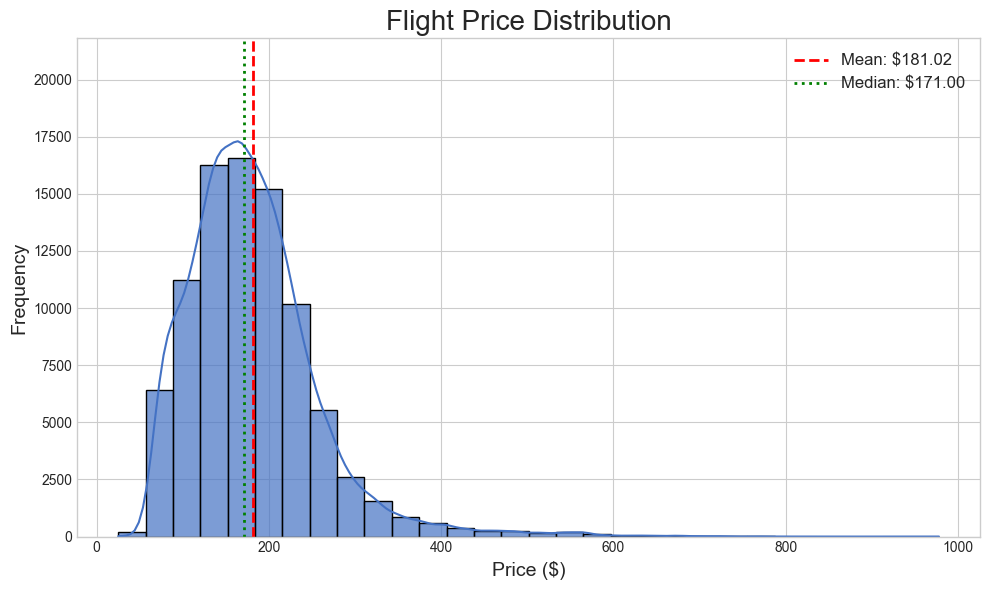

The target variable kurtosis is 5.9181971771863235
The target variable skew is 1.6523982658305754


In [13]:
def TargetCol(data): 
    '''Target column analysis - which in this case is the price column distribution'''
    plt.style.use('seaborn-v0_8-whitegrid')

    plt.figure(figsize=(10, 6))
    plt.title('Flight Price Distribution', fontsize=20)

    sns.histplot(data['price'], bins=30, kde=True, color='#4472C4', 
                edgecolor='black', alpha=0.7)

    mean_price = data['price'].mean()
    median_price = data['price'].median()
    plt.axvline(mean_price, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: ${mean_price:.2f}')
    plt.axvline(median_price, color='green', linestyle=':', linewidth=2, 
                label=f'Median: ${median_price:.2f}')

    plt.ylim(0, plt.ylim()[1] * 1.2)

    plt.xlabel('Price ($)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

    print(f"The target variable kurtosis is {kurtosis(data['price'])}")
    print(f"The target variable skew is {skew(data['price'])}")
    
TargetCol(data)

The results of the kurtosis and skew mean that the price target 

In [14]:
data_value_counts = data['to_dest_company'].value_counts()
data_value_counts = pd.DataFrame(data_value_counts).style.background_gradient("cool")
data_value_counts

,count
to_dest_company,
easyJet,25214
Vueling,18451
Ryanair,14337
Wizz Air,8555
ITA Airways,6273
British Airways,6151
Transavia France,3748
Air France,3084
Jet2,1097


There is A lot of data 

In [15]:
company_mapping = {
    'Wizz Air Malta': 'Wizz Air',
    'Wizz Air UK': 'Wizz Air',
    'Ryanair UK': 'Ryanair',
    'Multiple airlines': 'Other',
    'Scandinavian Airlines': 'SAS',
    'KM Malta Airlines': 'Other',
    'Aeroitalia': 'Other',
    'FlixBus': 'Other',
    'BlaBlaBus': 'Other',
    'Union Ivkoni': 'Other',
    'Brussels Airlines': 'Other',
    'SWISS': 'Other',
    'Volotea': 'Other'
}

data['to_dest_company'] = data['to_dest_company'].replace(company_mapping)
data['return_company'] = data['return_company'].replace(company_mapping)

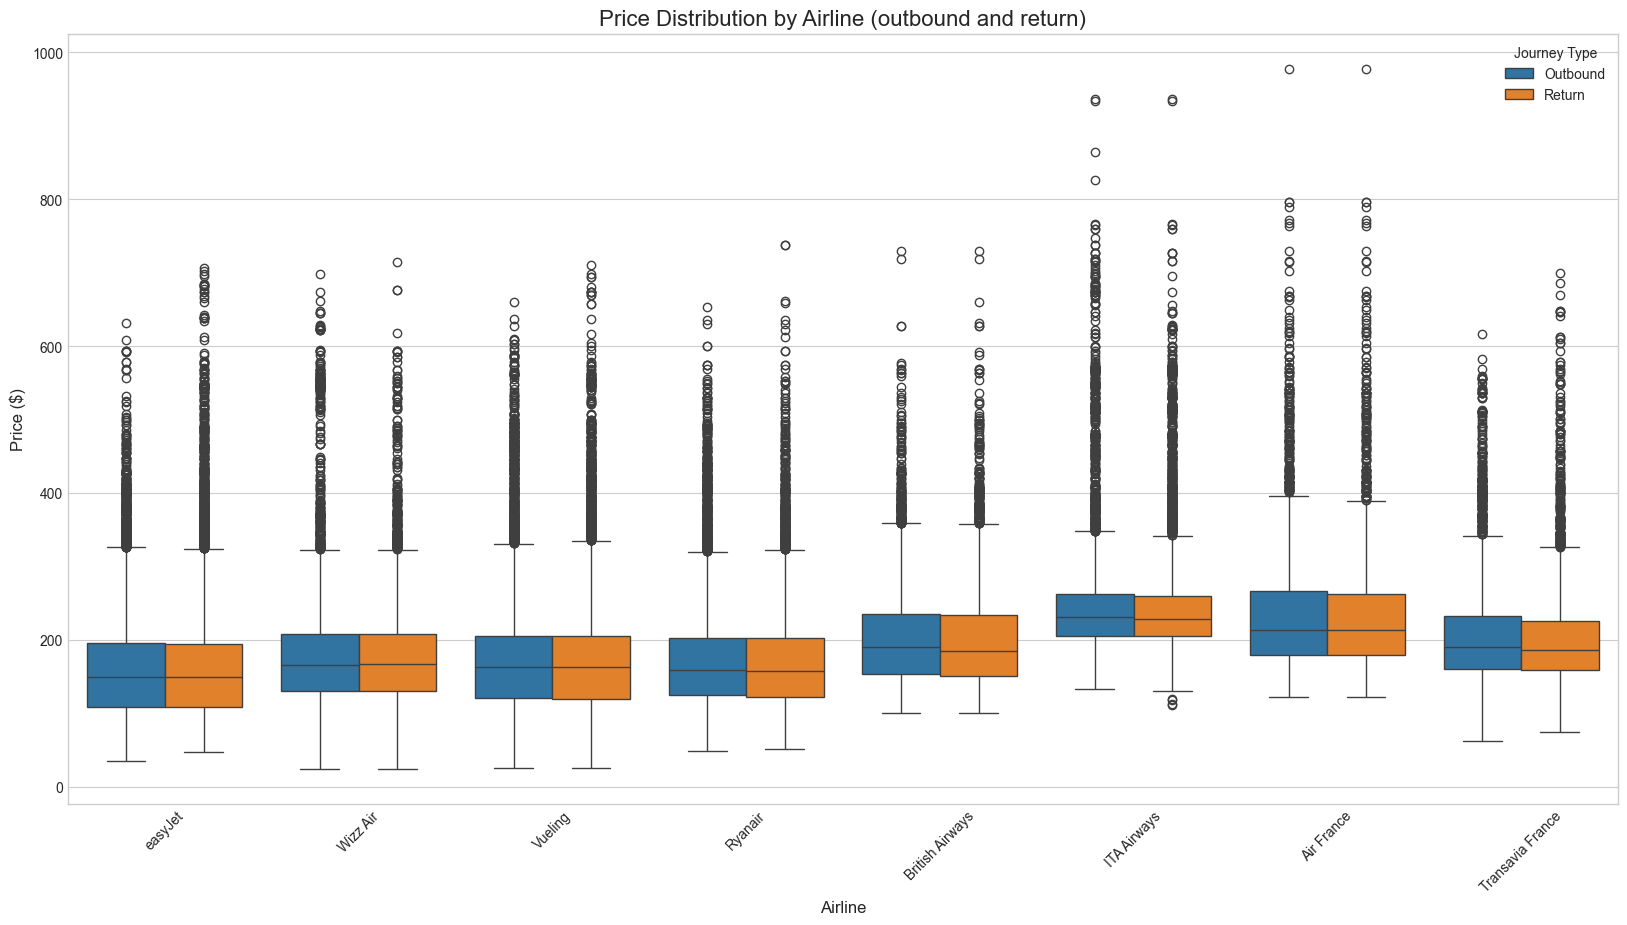

In [16]:
def price_per_airline(data):
    '''visualize dist of price per airway company (outbound and return)'''
    
    plt.figure(figsize=(20, 10))

    outbound_data = data[['price', 'to_dest_company']].copy()
    outbound_data['journey_type'] = 'Outbound'
    outbound_data.rename(columns={'to_dest_company': 'company'}, inplace=True)

    return_data = data[['price', 'return_company']].copy()
    return_data['journey_type'] = 'Return'
    return_data.rename(columns={'return_company': 'company'}, inplace=True)

    combined_data = pd.concat([outbound_data, return_data])

    # Get the top 10 most frequent airlines
    top_airlines = combined_data['company'].value_counts().nlargest(8).index.tolist()
    combined_data_filtered = combined_data[combined_data['company'].isin(top_airlines)]

    sns.boxplot(x='company', y='price', hue='journey_type', data=combined_data_filtered)
    plt.xlabel('Airline', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.title('Price Distribution by Airline (outbound and return)', fontsize=16)
    plt.xticks(rotation=45)
    plt.legend(title='Journey Type')

price_per_airline(data)

Although the original requirement focused on prices by operating company, we further split the analysis into outbound and return flights to better understand pricing patterns across the full travel experience.


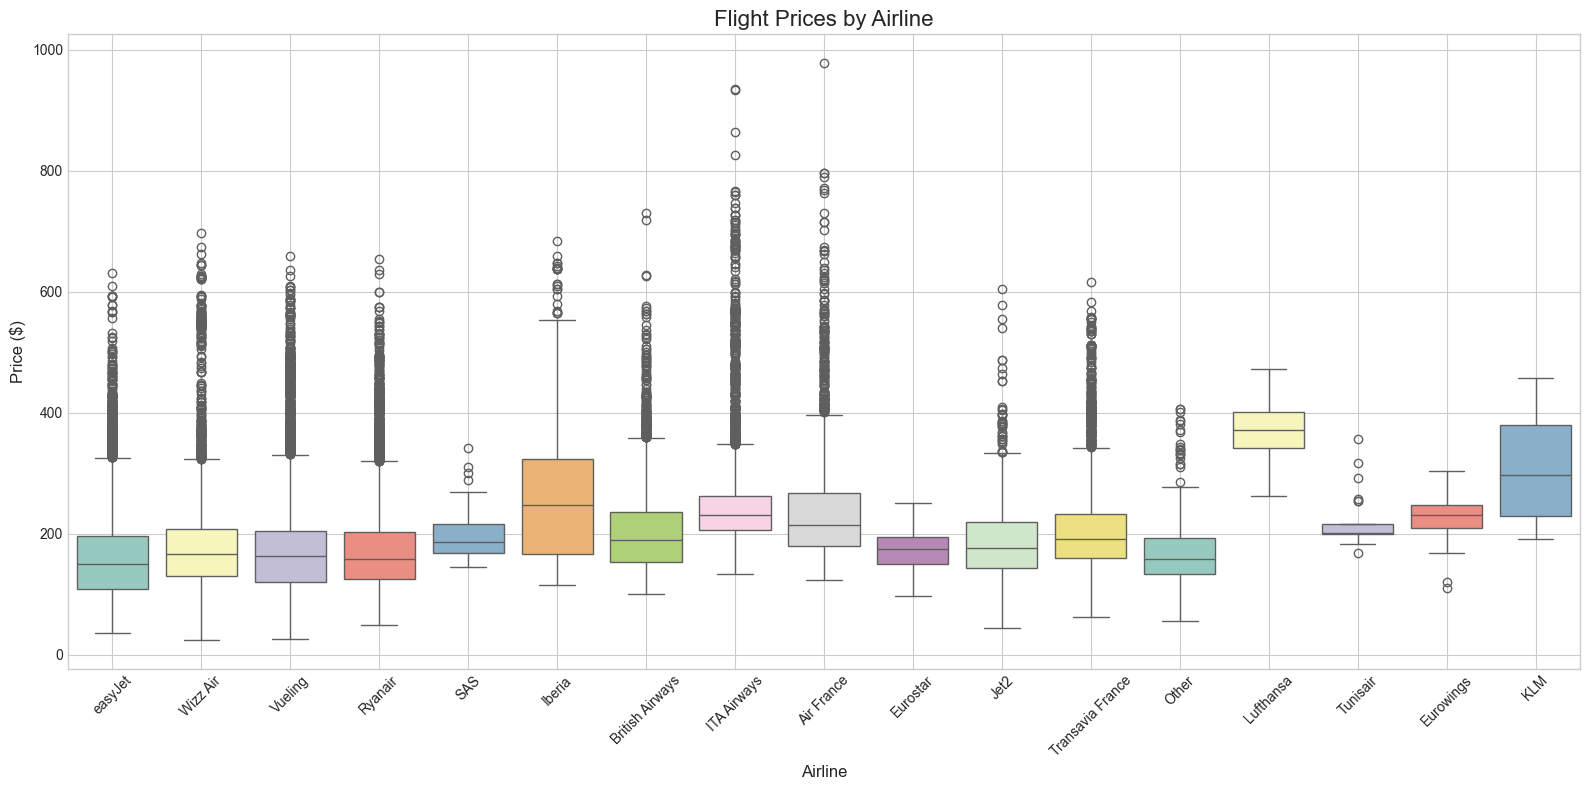

In [31]:
plt.figure(figsize=(16, 8))

sns.boxplot(
    data=data,
    x='to_dest_company',
    y='price',
    hue='to_dest_company',  
    palette='Set3',
    legend=False           
)

plt.xticks(rotation=45)
plt.title('Flight Prices by Airline', fontsize=16)
plt.xlabel('Airline', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()



In [23]:

top_airlines = data['to_dest_company'].value_counts().nlargest(8).index
filtered_data = data[data['to_dest_company'].isin(top_airlines)]

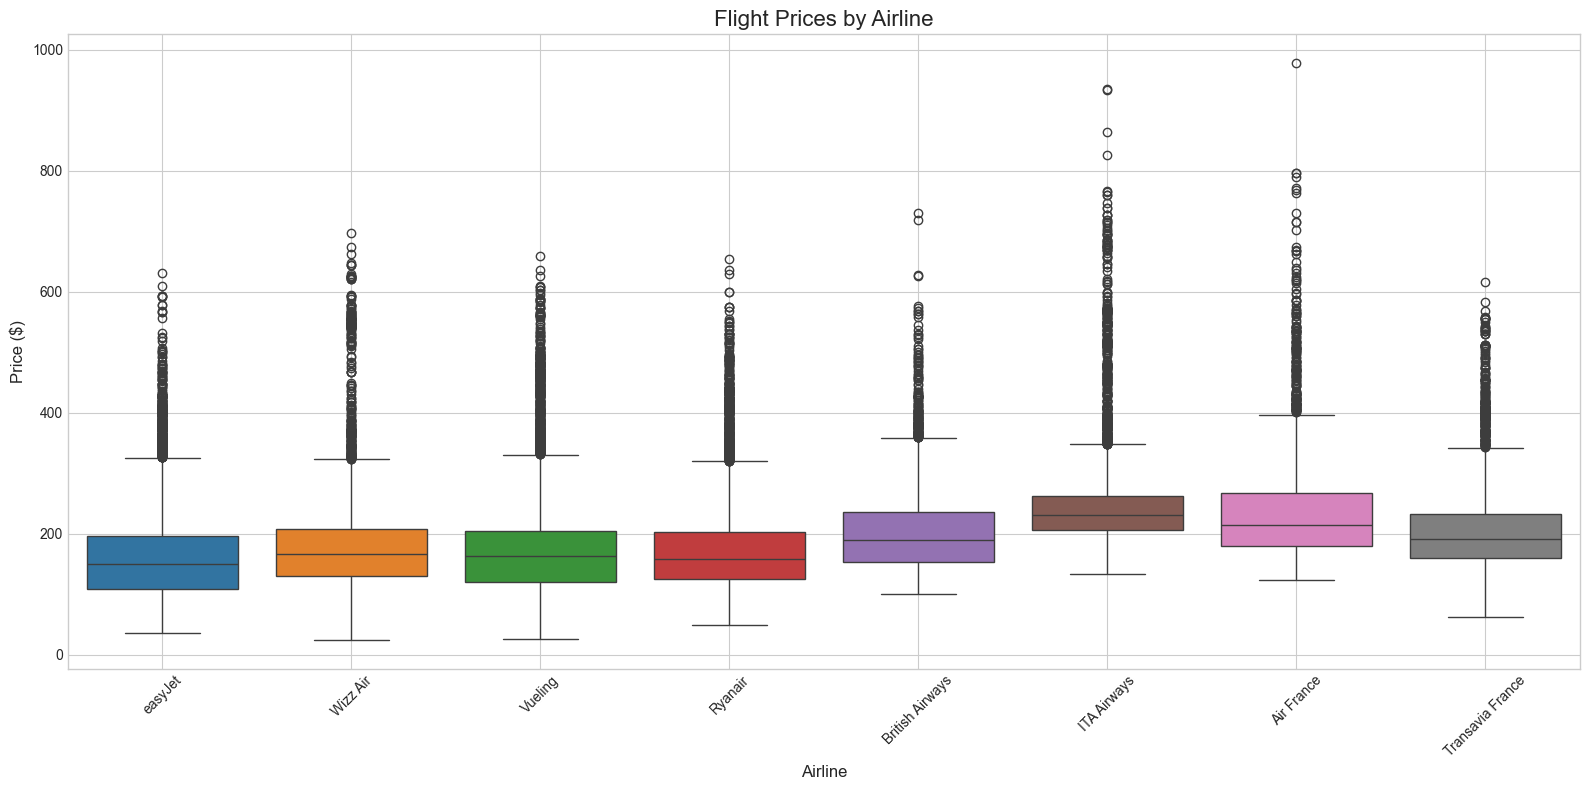

In [30]:
plt.figure(figsize=(16, 8))
sns.set_style("whitegrid")

sns.boxplot(
    data=filtered_data,
    x='to_dest_company',
    y='price',
    hue='to_dest_company',  
    legend=False          
)

plt.xticks(rotation=45)
plt.title('Flight Prices by Airline', fontsize=16)
plt.xlabel('Airline', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.tight_layout()
plt.grid(True)
plt.show()


now lets visualize the price per city (origin, destination anf total route)

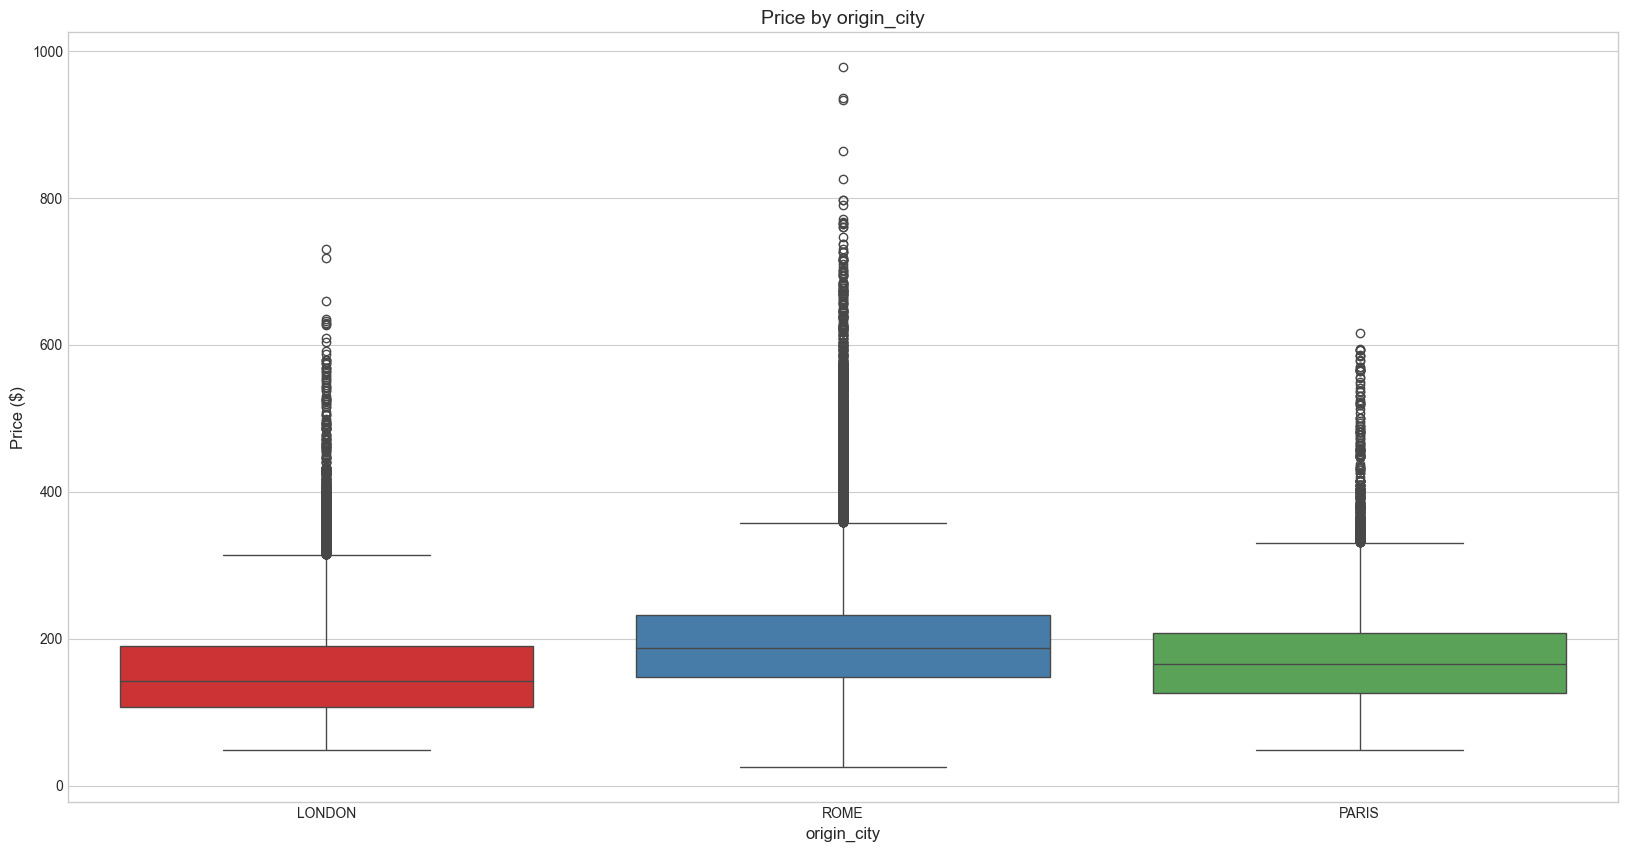

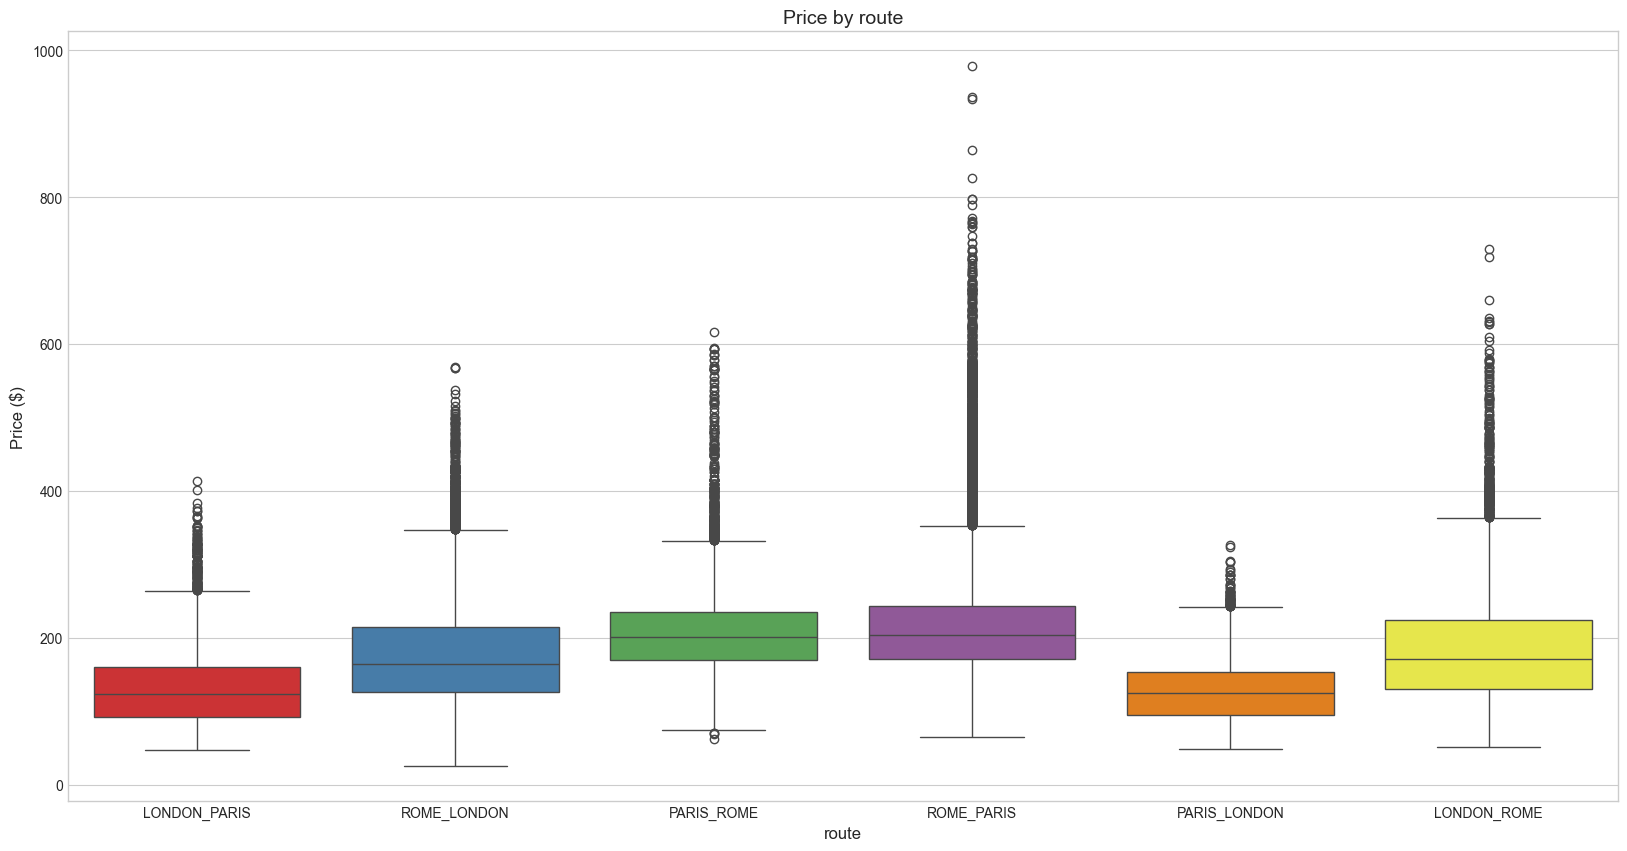

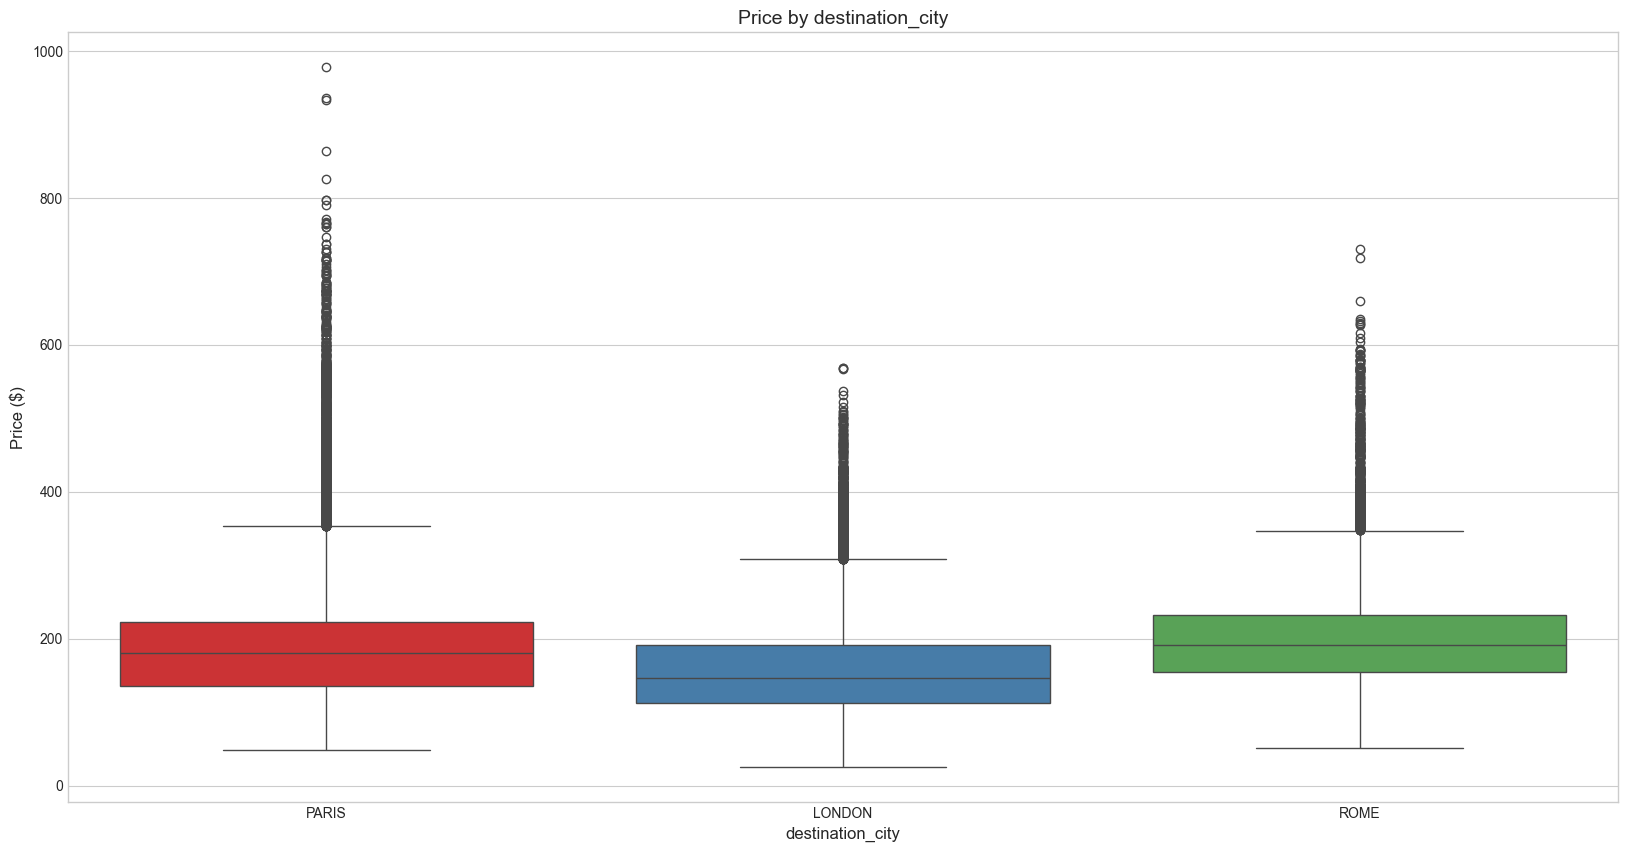

In [26]:
def price_per_feature(data, column: str):
    plt.figure(figsize=(20, 10))
    top_routes = data[column].value_counts().index.tolist()
    cities_data = data[data[column].isin(top_routes)]

    sns.boxplot(x=column, y='price', data=cities_data, hue=column, palette='Set1', legend=False)
    plt.title(f'Price by {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    
price_per_feature(data, 'origin_city')
price_per_feature(data, 'route')
price_per_feature(data, 'destination_city')

# Insights 

## Price by origin_city - 
Rome stands out as the most expensive origin city in Kayak, while London maintains its position as the most budget-friendly. Paris has a moderate price level with fewer fluctuations than Rome.

## Price by route - 
Flight routes involving Rome, especially the Rome–Paris direction, are consistently the most expensive with a wide distribution of prices and extreme highs. Routes such as London–Paris remain affordable and stable in comparison.

## Price by destination_city - 
Paris remains the most expensive destination across Kayak data, showing not only a higher median price but also a substantial number of extreme outliers. London stays consistently the cheapest destination.

### let check out the companies 

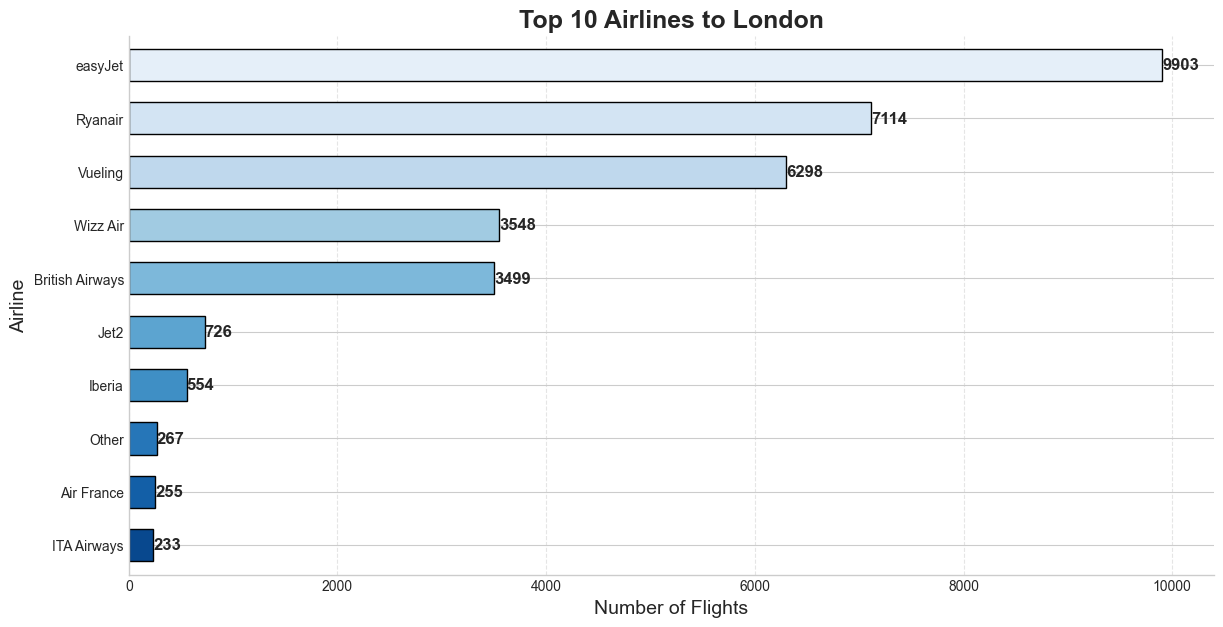

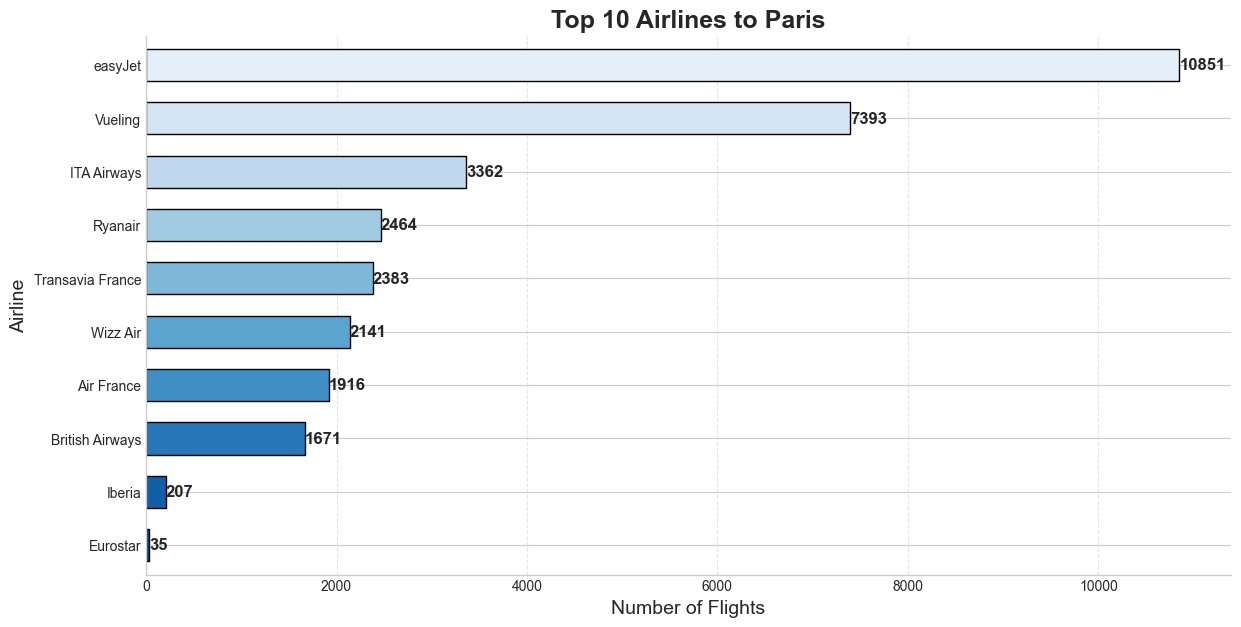

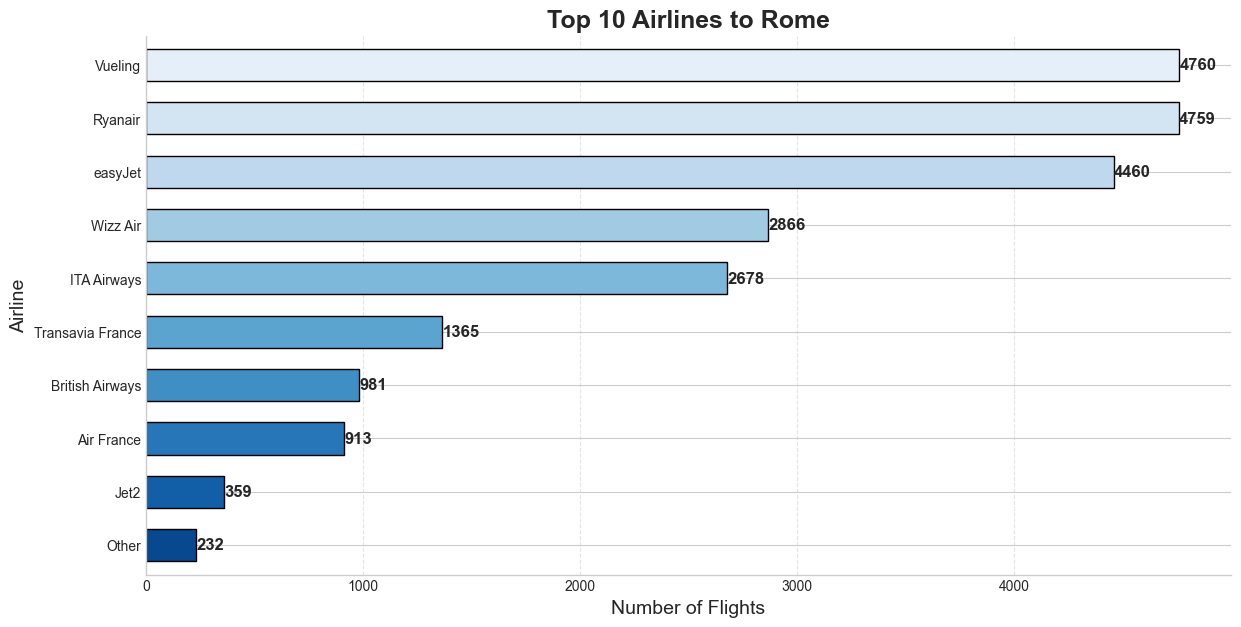

In [32]:
# Set seaborn style for better visualization
sns.set_style("whitegrid")

def top_airlines_per_city(data):
    flight_counts = data.groupby(["destination_city", "to_dest_company"]).size().unstack().fillna(0)

    # Get the top 5 airlines with the most flights for each destination
    london_flights = flight_counts.loc["LONDON"].nlargest(10)
    paris_flights = flight_counts.loc["PARIS"].nlargest(10)
    rome_flights = flight_counts.loc["ROME"].nlargest(10)

    # Plot the results
    flights_counts(london_flights, "London")
    flights_counts(paris_flights, "Paris")
    flights_counts(rome_flights, "Rome")

def flights_counts(dest_flight_counts, dest):
    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot sorted bar chart
    bars = dest_flight_counts.sort_values(ascending=True).plot(
        kind="barh", 
        ax=ax, 
        edgecolor="black", 
        width=0.6,  # Reduce bar spacing
        color=sns.color_palette("Blues_r", len(dest_flight_counts))
    )

    # Improve aesthetics
    ax.set_title(f"Top 10 Airlines to {dest}", fontsize=18, fontweight="bold")
    ax.set_xlabel("Number of Flights", fontsize=14)
    ax.set_ylabel("Airline", fontsize=14)
    ax.grid(axis="x", linestyle="--", alpha=0.5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    # Add value labels
    for bar in bars.patches:
        ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                f'{int(bar.get_width())}', 
                ha='left', va='center', fontsize=12, fontweight="bold")

    plt.show()

# Call the function
top_airlines_per_city(data)


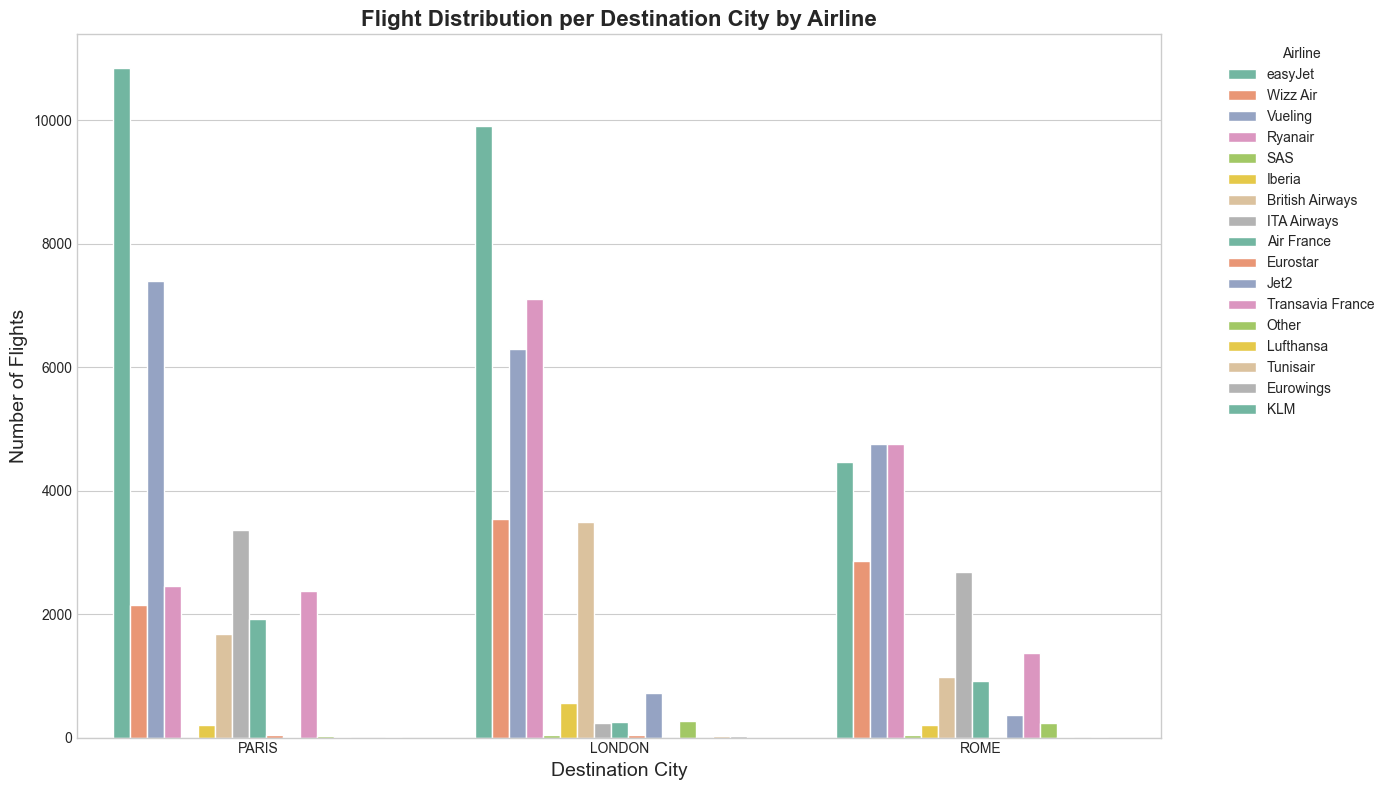

In [34]:
plt.figure(figsize=(14, 8))
sns.countplot(
    x='destination_city',
    hue='to_dest_company',  
    data=data,
    palette='Set2'
)

plt.title("Flight Distribution per Destination City by Airline", fontsize=16, fontweight='bold')
plt.xlabel("Destination City", fontsize=14)
plt.ylabel("Number of Flights", fontsize=14)
plt.legend(title="Airline", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Insights

- **Paris**: Dominated by KLM, with additional high activity from Wizz Air, easyJet, and Ryanair.
- **London**: Also led by KLM, followed by easyJet, Wizz Air, and British Airways.
- **Rome**: More balanced distribution across airlines, without a clear market leader.

 Cities like Paris and London show concentrated airline activity, suggesting stronger competition and possibly lower prices.  
 Rome shows a more even spread, which may explain greater price variability.

destination

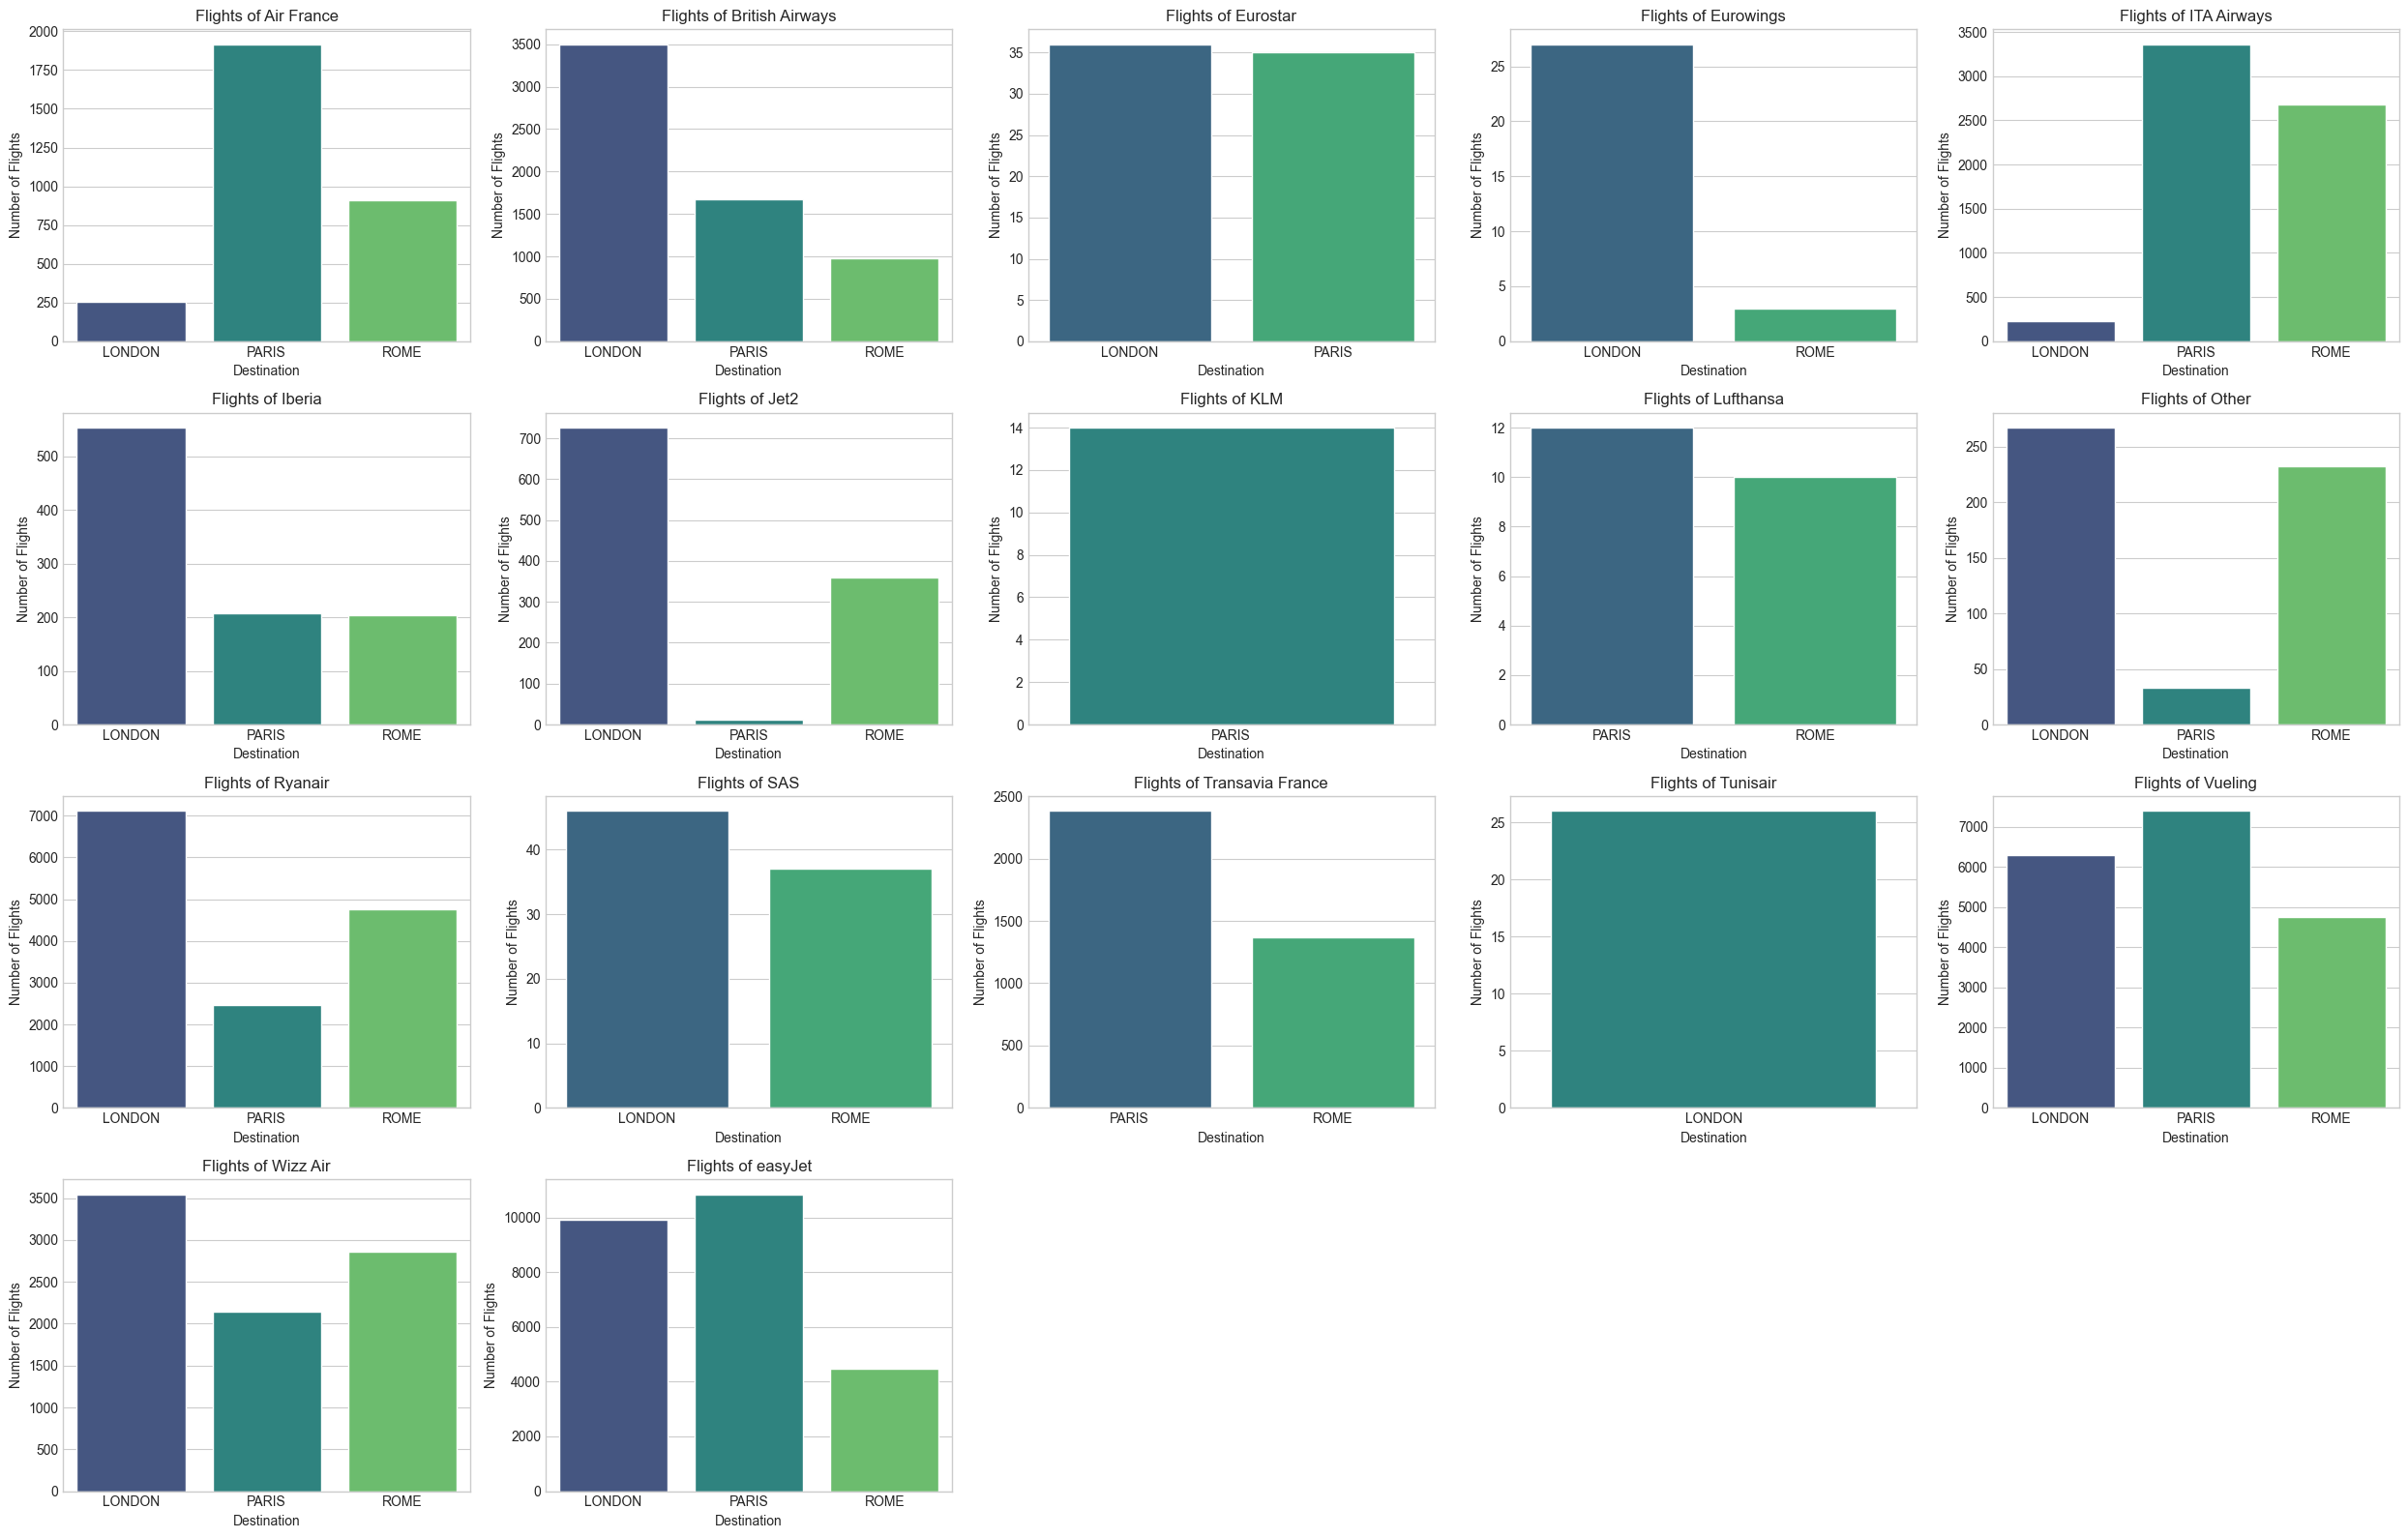

In [42]:
def flights_per_company(data):
    # Group data by flight company and destination, then count flights
    flight_counts = data.groupby(['to_dest_company', 'destination_city']).size().reset_index(name='count')

    # Get unique airlines
    airlines = flight_counts['to_dest_company'].unique()
    num_airlines = len(airlines)
    num_rows = int(np.ceil(num_airlines / 5))

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(25, 4 * num_rows))
    axes = axes.flatten()

    # Plot barplot for each airline
    for i, airline in enumerate(airlines):
        subset = flight_counts.loc[flight_counts['to_dest_company'] == airline].copy()
        # Explicitly group the subset by destination city
        grouped_subset = subset.groupby('destination_city')['count'].sum().reset_index()
        sns.barplot(
            x='destination_city',
            y='count',
            hue='destination_city',          
            data=grouped_subset,
            palette='viridis',
            dodge=False,
            ax=axes[i]
        )
        axes[i].set_title(f'Flights of {airline}')
        axes[i].set_xlabel('Destination')
        axes[i].set_ylabel('Number of Flights')
         

    # Hide extra subplots
    for i in range(len(airlines), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

flights_per_company(data)



origin

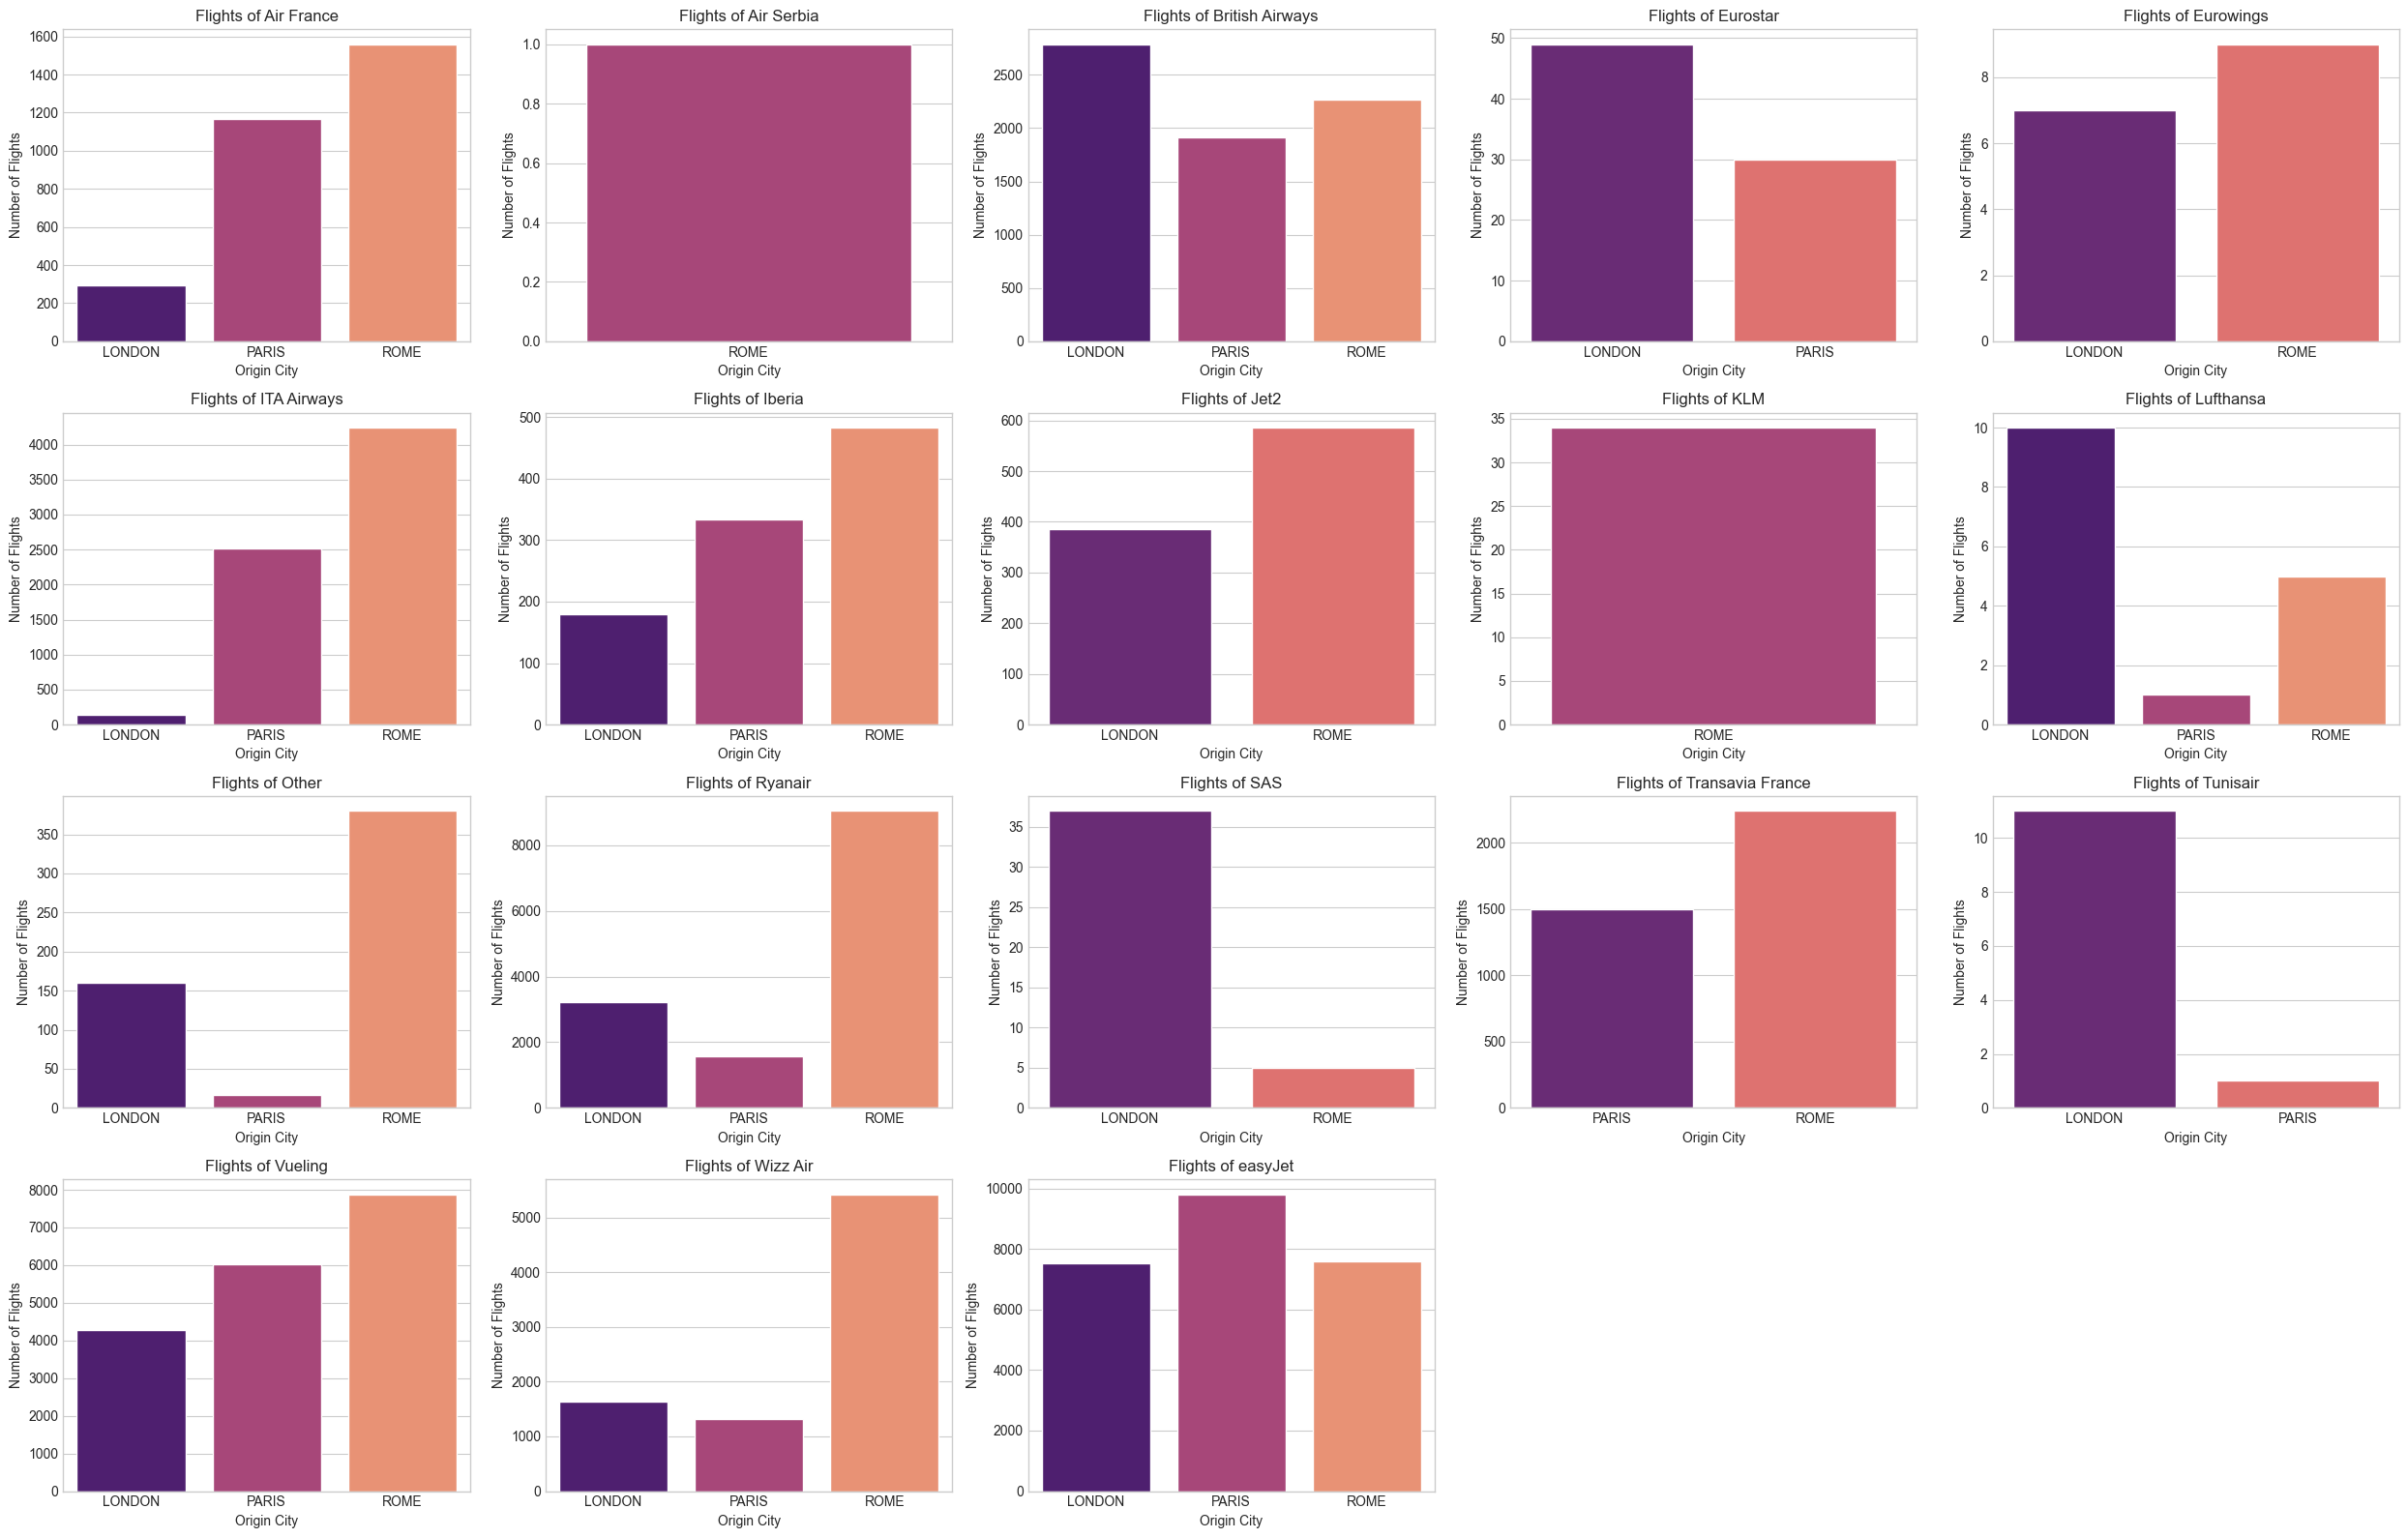

In [46]:
def flight_by_origin_city(data):
    # Group data by flight company and origin city, then count flights
    flight_counts = data.groupby(['return_company', 'origin_city']).size().reset_index(name='count')

    # Get unique airlines
    airlines = flight_counts['return_company'].unique()
    num_airlines = len(airlines)
    num_rows = int(np.ceil(num_airlines / 5))

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(25, 4 * num_rows))
    axes = axes.flatten()

    # Plot barplot for each airline
    for i, airline in enumerate(airlines):
        subset = flight_counts.loc[flight_counts['return_company'] == airline].copy()
        grouped_subset = subset.groupby('origin_city')['count'].sum().reset_index()
        sns.barplot(
            x='origin_city',
            y='count',
            hue='origin_city',         
            dodge=False,               
            data=grouped_subset,
            ax=axes[i],
            palette='magma'
        )
        axes[i].set_title(f'Flights of {airline}')
        axes[i].set_xlabel('Origin City')
        axes[i].set_ylabel('Number of Flights')
        

    # Hide extra subplots
    for i in range(len(airlines), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

flight_by_origin_city(data)


### Kayak – Flights Distribution Insights

- **More airlines** included compared to Kiwi, offering broader route diversity.  
- **Key hubs:** London, Paris, and Rome frequently appear as both origins and destinations.  
- **Dominant low-cost carriers:** EasyJet, Ryanair, and Wizz Air operate most of the flights.  
- **Unbalanced flight patterns** in some airlines between origin and destination cities.  
- **Small carriers** like Air Serbia and Tunisair operate very few routes.

> These insights reflect strategic focus areas and market presence in European air travel.


### Layovers

#### outbound layover

C:\Users\LaurenM\AppData\Local\Temp\ipykernel_14144\2603749112.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


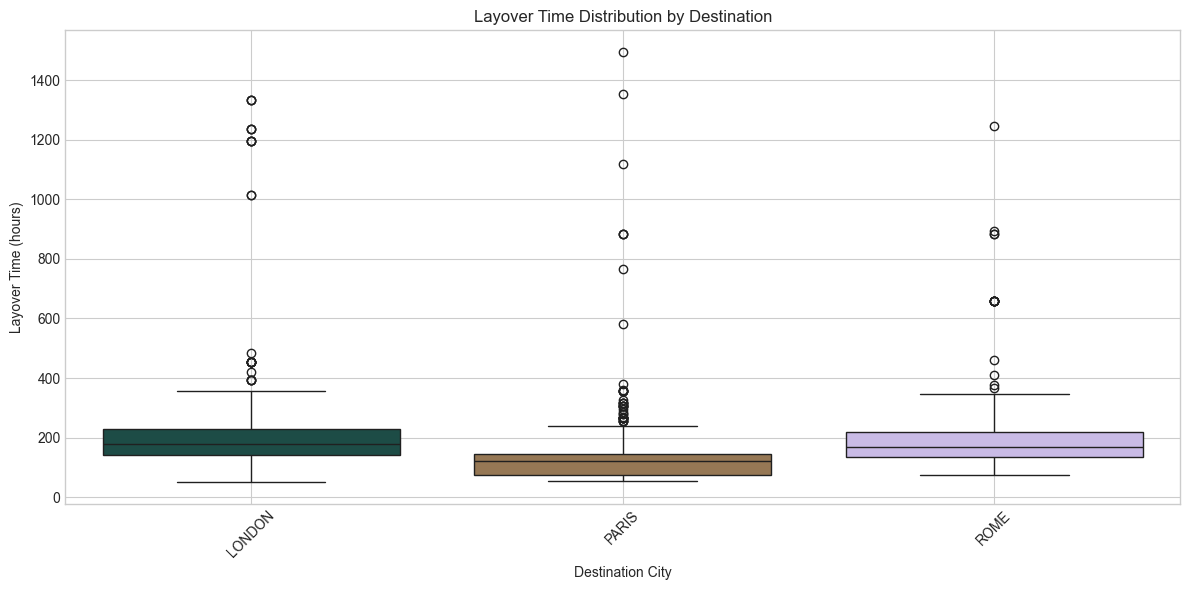

,Mean Layover,Median Layover,Min Layover,Max Layover,Layover Std Dev
destination_city,,,,,
LONDON,196.85,180.0,50,1335,136.93
PARIS,132.26,120.0,53,1495,105.87
ROME,182.27,170.0,75,1245,95.13


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_layover_time(data):
    layover_data = data[(data['layover'] == True) & (data['layover_time'] > 0)]

    plt.figure(figsize=(12, 6))
    sns.boxplot(
        x='destination_city',
        y='layover_time',
        data=layover_data,
        palette='cubehelix',
        hue=None 
    )
    plt.title('Layover Time Distribution by Destination')
    plt.xlabel('Destination City')
    plt.ylabel('Layover Time (hours)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def group_destcity_layovertime(data):
    summary = (
        data[data['layover_time'] > 0]
        .groupby('destination_city')['layover_time']
        .agg([
            ('Mean Layover', 'mean'),
            ('Median Layover', 'median'),
            ('Min Layover', 'min'),
            ('Max Layover', 'max'),
            ('Layover Std Dev', 'std')
        ])
        .round(2)
    )
    display(summary)

def layover_time(data):
    plot_layover_time(data)
    group_destcity_layovertime(data)


layover_time(data)


if there is a layover, price dist over time of layover per dest

C:\Users\LaurenM\AppData\Local\Temp\ipykernel_14144\3542154012.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='destination_city', y='return_layover_time', data=layover_data, palette='icefire')


,Mean Layover,Median Layover,Min Layover,Max Layover,Layover Std Dev
destination_city,,,,,
LONDON,5.57,0.0,0,1245,36.79
PARIS,3.95,0.0,0,1495,30.77
ROME,6.58,0.0,0,1415,39.98


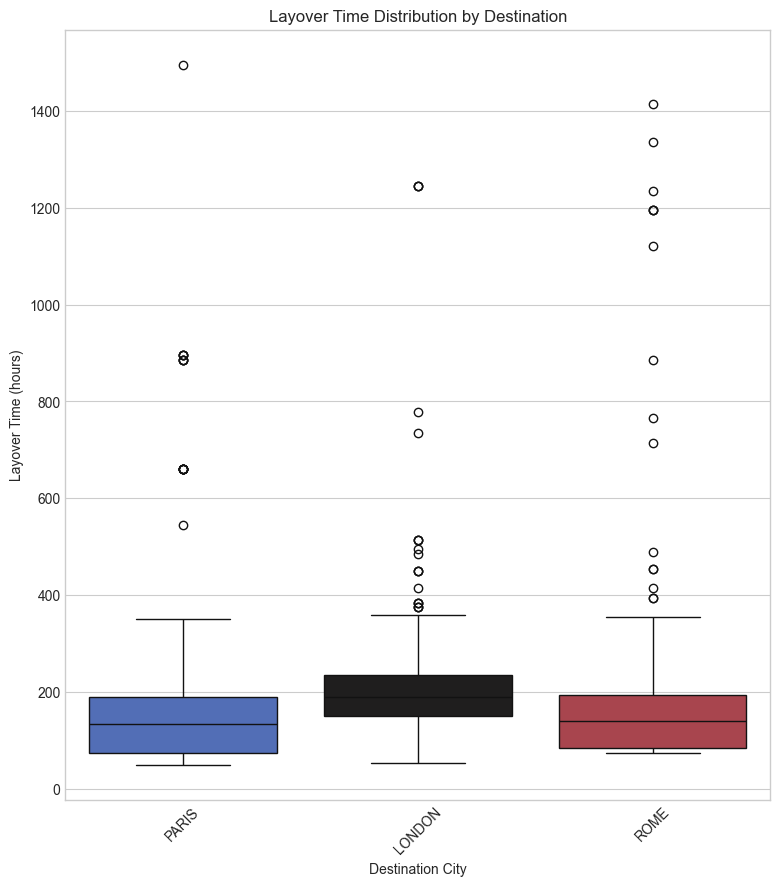

In [52]:
def plot_layover_return_time(data):
    layover_data = data[data['layover']== True]
    layover_data = layover_data[layover_data['return_layover_time'] > 0]
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    sns.boxplot(x='destination_city', y='return_layover_time', data=layover_data, palette='icefire')
    plt.title('Layover Time Distribution by Destination')
    plt.xlabel('Destination City')
    plt.ylabel('Layover Time (hours)')
    plt.xticks(rotation=45)


def group_destcity_return_layovertime(data):
    # Calculate summary statistics
    display(data.groupby('destination_city')['return_layover_time'].agg([
        ('Mean Layover', 'mean'),
        ('Median Layover', 'median'),
        ('Min Layover', 'min'),
        ('Max Layover', 'max'),
        ('Layover Std Dev', 'std')
    ]).round(2))

def return_layover_time(data):
    plot_layover_return_time(data)
    group_destcity_return_layovertime(data)
    
return_layover_time(data)

departure airport per city price influance

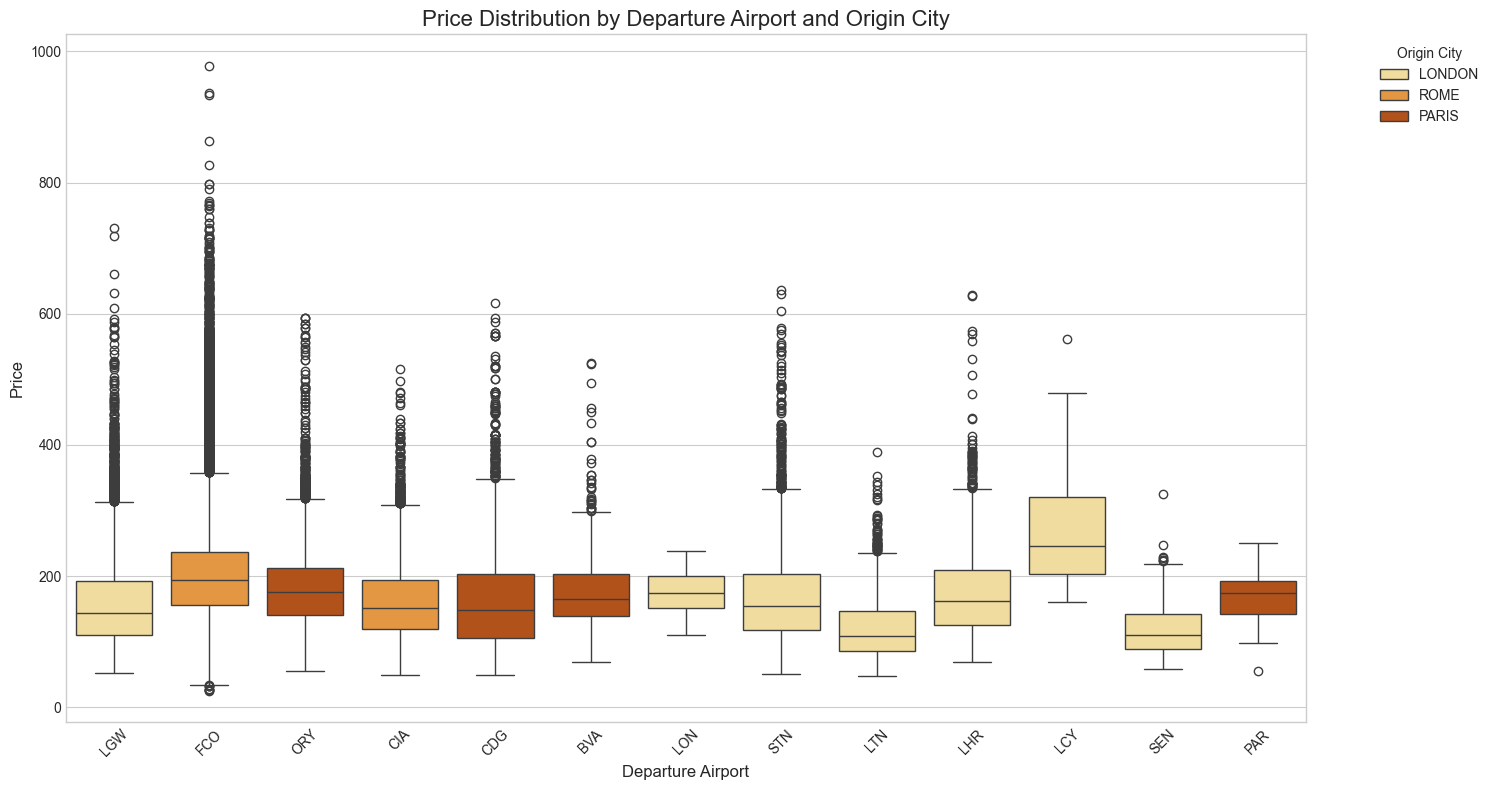

In [53]:
def price_per_deptair_origcity(data):
    plt.figure(figsize=(15, 8))
        
    # Create a box plot to show price distribution by departure airport for each origin city
    sns.boxplot(x='departure_airport', y='price', hue='origin_city', data=data ,palette='YlOrBr')

    plt.title('Price Distribution by Departure Airport and Origin City', fontsize=16)
    plt.xlabel('Departure Airport', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Origin City', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

def group_origincity_deptairport(data):
    # Calculate summary statistics
    data.groupby(['origin_city', 'departure_airport'])['price'].agg([
        ('Mean Price', 'mean'),
        ('Median Price', 'median'),
        ('Min Price', 'min'),
        ('Max Price', 'max'),
        ('Price Std Dev', 'std'),
        ('Number of Flights', 'count')
    ]).round(2)

price_per_deptair_origcity(data)
group_origincity_deptairport(data)

C:\Users\LaurenM\AppData\Local\Temp\ipykernel_14144\1202960042.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='time_category', y='price', data=data, palette='cubehelix')


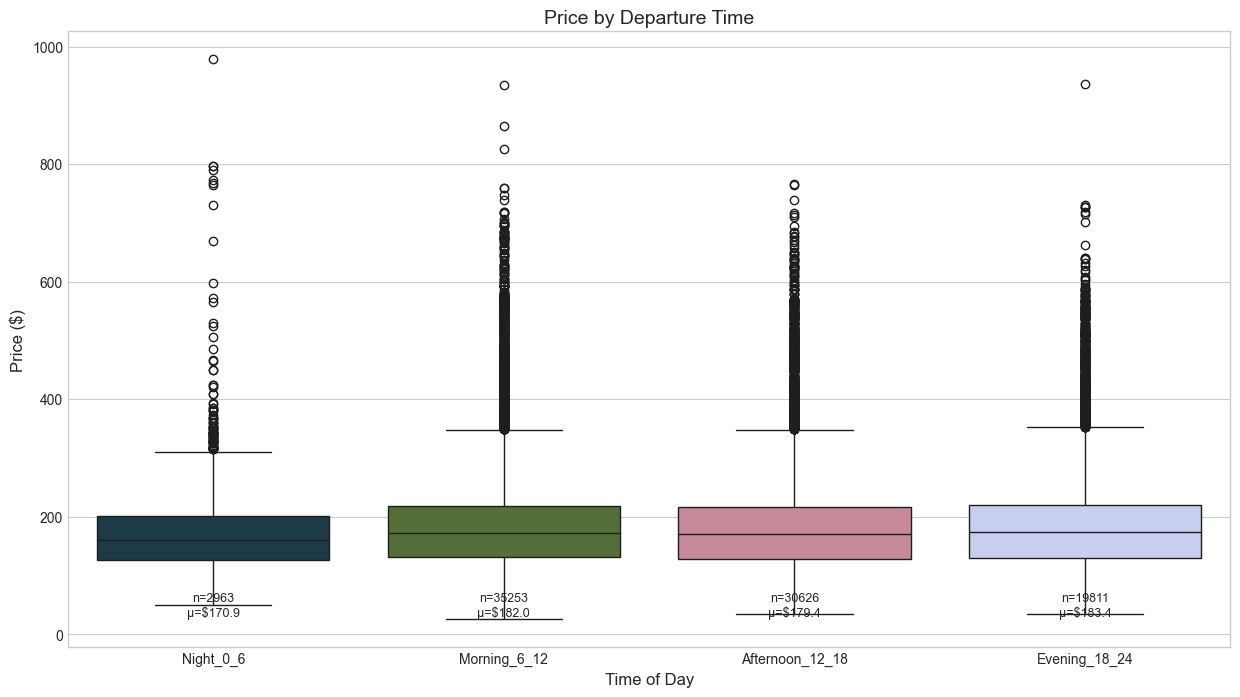

In [54]:
plt.figure(figsize=(15, 8))

# Create time categories
data['time_category'] = pd.cut(
    data['departure_hour'], 
    bins=[0, 6, 12, 18, 24],
    labels=['Night_0_6', 'Morning_6_12', 'Afternoon_12_18', 'Evening_18_24']
)

sns.boxplot(x='time_category', y='price', data=data, palette='cubehelix')
plt.title('Price by Departure Time', fontsize=14)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)

# Add count and mean annotations
for i, category in enumerate(data['time_category'].cat.categories):
    count = data[data['time_category'] == category].shape[0]
    mean = data[data['time_category'] == category]['price'].mean()
    plt.annotate(f'n={count}\nμ=${mean:.1f}', 
                        xy=(i, data['price'].min()), 
                        ha='center', va='bottom', fontsize=9)

## Price Distribution by Departure Time – Findings

Analyzing ticket prices by time of day revealed the following:

- **Night (00:00–06:00)** flights are the **cheapest on average** ($170.9), making them a cost-effective choice for flexible travelers.
- **Morning (06:00–12:00)** has the **highest number of flights** (n=35,253), with an average price of $182.
- **Afternoon (12:00–18:00)** and **Evening (18:00–24:00)** flights show similar average prices ($182–$183), with no major cost difference between them.
- All time segments show a wide price range with multiple outliers.

 **Conclusion:**  
Flights departing at **night** are generally the most affordable.  
Daytime flights (morning, afternoon, evening) are **equally priced on average**, but night flights provide better value for budget-conscious passengers.


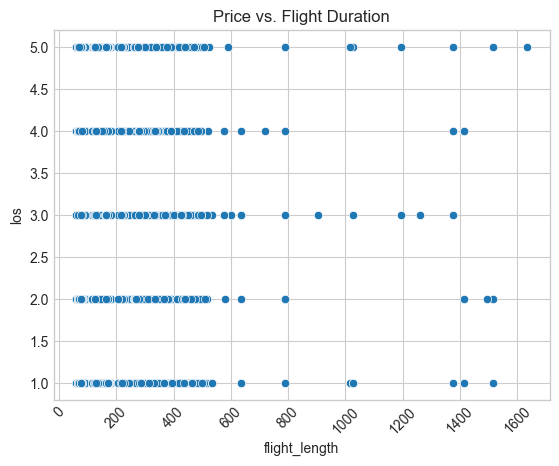

In [60]:
sns.scatterplot(x='flight_length', y='los', data=data)
plt.title('Price vs. Flight Duration')
plt.xticks(rotation=45)
plt.show()


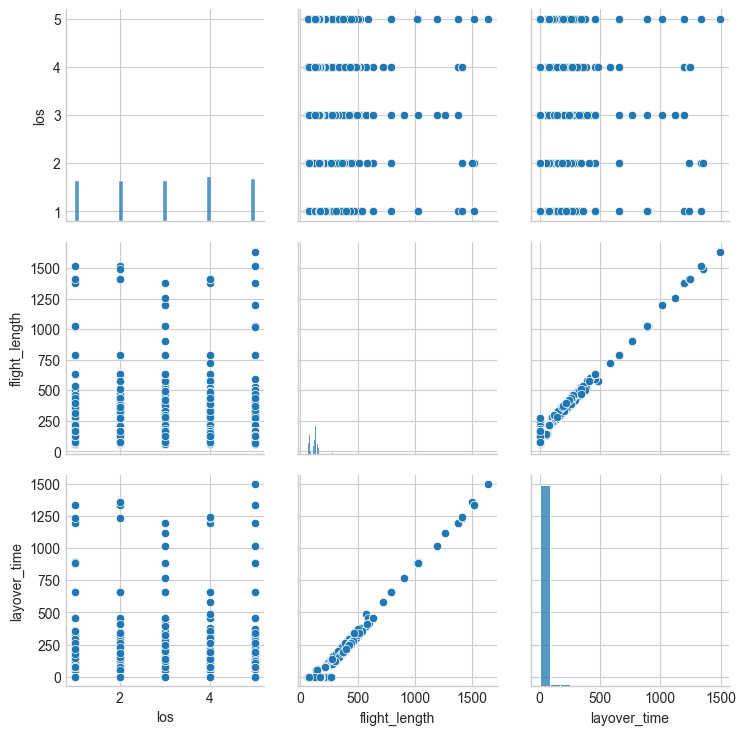

In [61]:
import seaborn as sns
g = sns.PairGrid(data[['los', 'flight_length', 'layover_time']])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)


## PairGrid – Exploring Relationships Between Variables

We analyzed the relationship between:

- **flight_length** (total duration)
- **layover_time** (connection time)
- **los** (ticket price)

### Key Observations:

- There's a strong positive correlation between `flight_length` and `layover_time`, which is expected, as longer total travel time usually includes layovers.
- The relationship between `layover_time` and `los` appears weak – more layovers don't necessarily result in cheaper flights.
- The scatterplot of `flight_length` vs. `los` shows that **flight duration has no clear impact on price**, suggesting other factors (like destination, airline, and timing) may play a larger role in pricing.


# Remove the outlier (Tukey method: 1.5*IQR)

In [66]:
def remove_route_outliers(group):
    Q1 = group['price'].quantile(0.25)
    Q3 = group['price'].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return group[(group['price'] >= lower_bound) & 
                        (group['price'] <= upper_bound)]

#### Lets visualize before and after removing the outlier (price over route)

C:\Users\LaurenM\AppData\Local\Temp\ipykernel_14144\2674912080.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_cleaned = data.groupby('route', group_keys=False).apply(remove_route_outliers).reset_index(drop=True)
C:\Users\LaurenM\AppData\Local\Temp\ipykernel_14144\2674912080.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='route', y='price', data=data, palette='viridis')


Original DataFrame size: 85237
Cleaned DataFrame size: 85096
Number of outliers removed: 141
Percentage of data removed: 0.17%


C:\Users\LaurenM\AppData\Local\Temp\ipykernel_14144\2674912080.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='route', y='price', data=data_cleaned, palette='magma')



Price Statistics - Original Data:
              Mean Price  Median Price  Min Price  Max Price  Price Std Dev  \
route                                                                         
LONDON_PARIS      128.84         123.0       48.0      259.0          44.16   
LONDON_ROME       176.45         168.0       51.0      351.0          63.00   
PARIS_LONDON      126.87         125.0       49.0      242.0          39.08   
PARIS_ROME        201.94         199.0       75.0      326.0          45.59   
ROME_LONDON       170.08         161.0       25.0      334.0          59.28   
ROME_PARIS        201.24         198.0       73.0      330.0          47.04   

              Total Flights  
route                        
LONDON_PARIS          11080  
LONDON_ROME            9105  
PARIS_LONDON          11941  
PARIS_ROME            13792  
ROME_LONDON           19898  
ROME_PARIS            19421  

Price Statistics - Cleaned Data:
              Mean Price  Median Price  Min Price  Max Pri

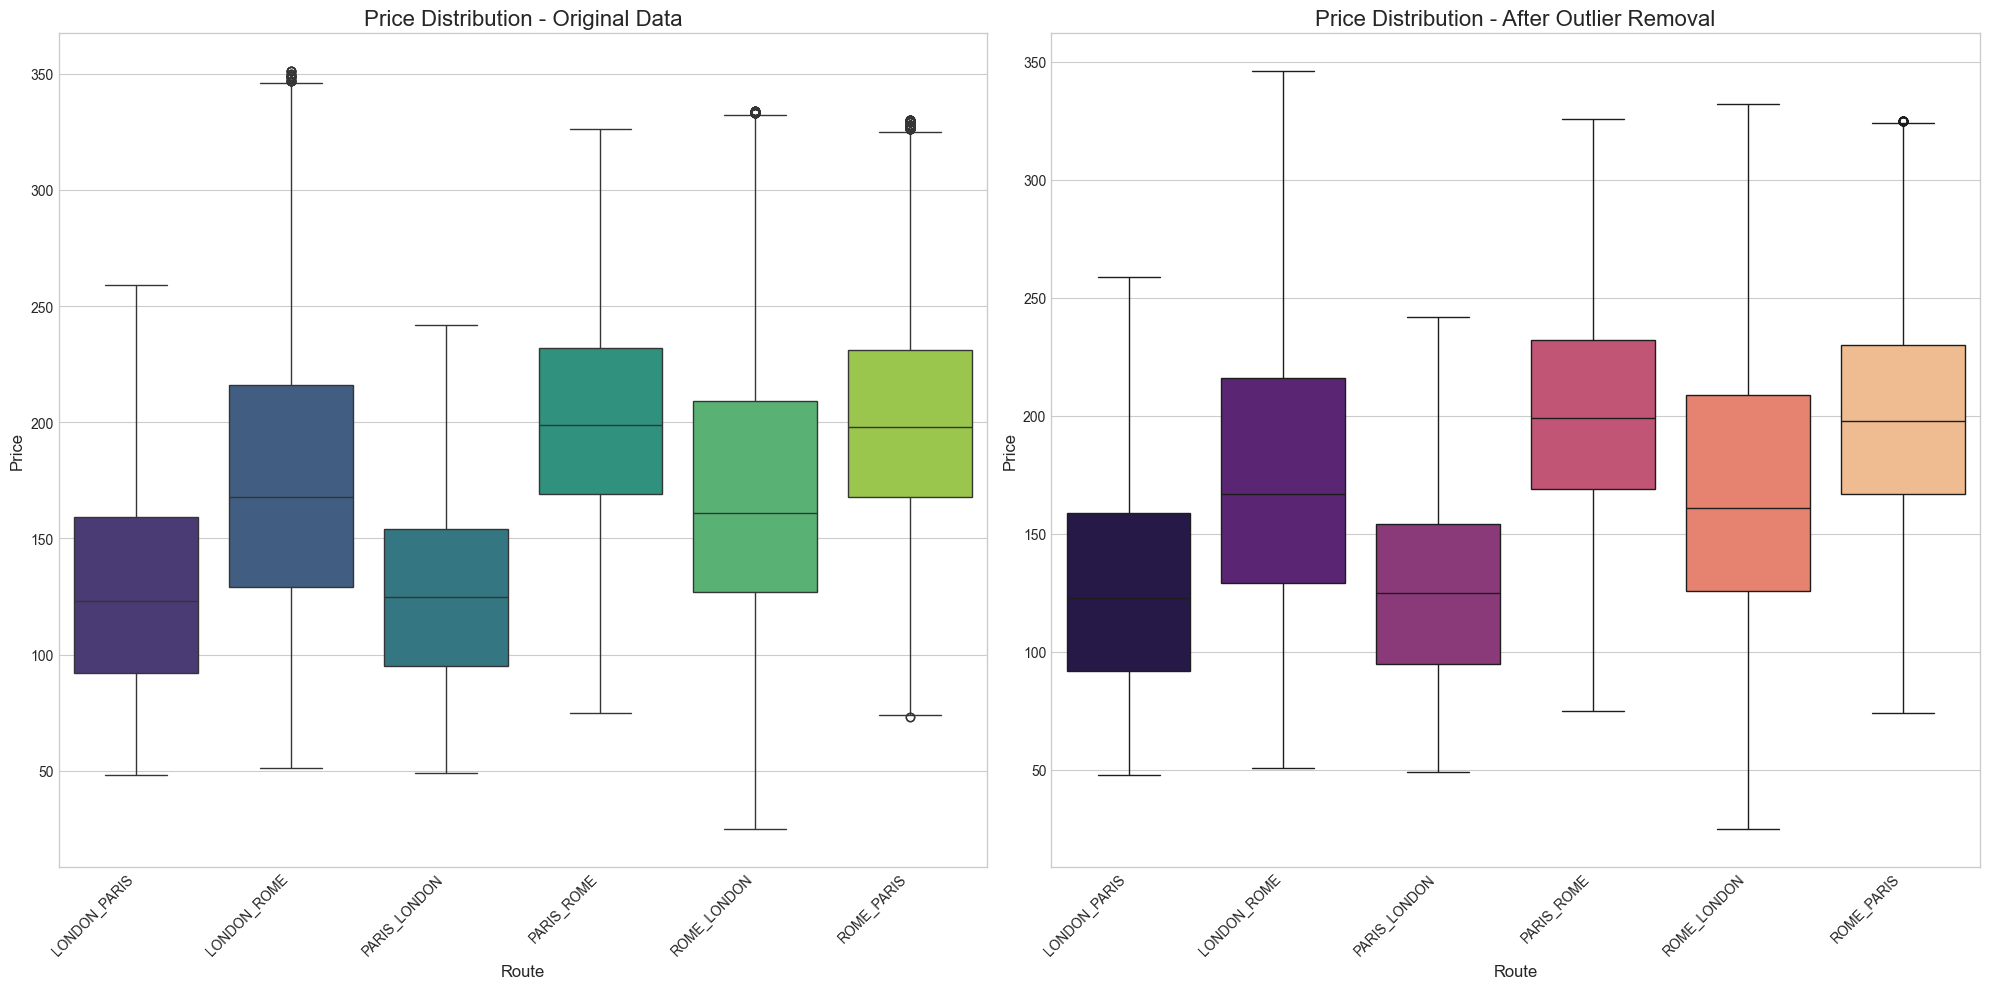

In [69]:
# Group by route and remove outliers
data_cleaned = data.groupby('route', group_keys=False).apply(remove_route_outliers).reset_index(drop=True)

# Print removal statistics
original_count = len(data)
cleaned_count = len(data_cleaned)
removed_count = original_count - cleaned_count

print(f"Original DataFrame size: {original_count}")
print(f"Cleaned DataFrame size: {cleaned_count}")
print(f"Number of outliers removed: {removed_count}")
print(f"Percentage of data removed: {removed_count/original_count*100:.2f}%")

# Set up the figure with two subplots
plt.figure(figsize=(20, 10))

# Original Data Distribution
plt.subplot(1, 2, 1)
sns.boxplot(x='route', y='price', data=data, palette='viridis')
plt.title('Price Distribution - Original Data', fontsize=16)
plt.xlabel('Route', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Cleaned Data Distribution
plt.subplot(1, 2, 2)
sns.boxplot(x='route', y='price', data=data_cleaned, palette='magma')
plt.title('Price Distribution - After Outlier Removal', fontsize=16)
plt.xlabel('Route', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Adjust layout and save
plt.tight_layout()

# Additional statistical summary
print("\nPrice Statistics - Original Data:")
original_stats = data.groupby('route')['price'].agg([
    ('Mean Price', 'mean'),
    ('Median Price', 'median'),
    ('Min Price', 'min'),
    ('Max Price', 'max'),
    ('Price Std Dev', 'std'),
    ('Total Flights', 'count')
]).round(2)
print(original_stats)

print("\nPrice Statistics - Cleaned Data:")
cleaned_stats = data_cleaned.groupby('route')['price'].agg([
    ('Mean Price', 'mean'),
    ('Median Price', 'median'),
    ('Min Price', 'min'),
    ('Max Price', 'max'),
    ('Price Std Dev', 'std'),
    ('Total Flights', 'count')
]).round(2)
print(cleaned_stats)
data = data_cleaned

### Price Distribution – Kayak Dataset (Before & After Outlier Removal)

- **Before Cleaning**:
  - Significant number of outliers, especially on routes like `LONDON_ROME` and `ROME_LONDON`.
  - High price variability, making it harder to detect consistent pricing patterns.

- **After Cleaning**:
  - Outliers were removed using the Tukey method (1.5 * IQR).
  - Clearer, more compact distributions.
  - Price differences between routes remained consistent:
    - `ROME_PARIS` and `PARIS_ROME` remain the most expensive.
    - `LONDON_PARIS` and `PARIS_LONDON` are the cheapest routes.
  - Data is now more reliable for modeling and analysis.
